In [2]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


### This notebook seeks to recreate the algorithm used in calculateDeltaTConstants.C from Jason in python, hopefully in a way that is a little more readable.

We will use the method detailed in note 16841 to construct a matrix of deltaT clusters for adjacent crystals in each calorimeter, and then use SciPy singular value decomposition in order to arrive at the xtal-to-xtal timing alignment constants for each calorimeter.

* Matrix = 1/-1 depending on the calorimeters being subtracted

* RHS = vector of deltaT values (mean from gaussian fit)

Both of these should be divided by the error in the mean from the gaussian fit

---

In [3]:
#open the file containing the hitDeltaTXXX histograms. These are produced as an output from:
#    https://cdcvs.fnal.gov/redmine/projects/gm2calo/repository/entry/analyses/NeighboringCrystalsTimeExtraction_module.cc?rev=run2Templates
#f = r.TFile("./data/gm2deltaTAnalysis_full.root")
#f = r.TFile("./data/positrons_head_WithEnergyCorrection.root") #just a couple subruns with proper energy calibration
#f = r.TFile("./data/results_IntraCaloTiming.root") #all subruns with proper energy calibration
#f = r.TFile("./data/positronRuns_head_withPreliminaryTimingCorrection.root") #produced post correction

f = r.TFile("./data/results_deltaT_intra_postDisk_withEnergyCalibration.root") #all subruns with energy calib. post disk
f = r.TFile("./data/post_disk/results_Jan10_deltaT.root")

f.cd("neighboringCrystalsDeltaT")
f.ls()

TFile**		./data/post_disk/results_Jan10_deltaT.root	
 TFile*		./data/post_disk/results_Jan10_deltaT.root	
  TDirectoryFile*		neighboringCrystalsDeltaT	neighboringCrystalsDeltaT (NeighboringCrystalsTimeExtraction) folder
   KEY: TH3D	hitDeltaT0;1	calo 0 delta t
   KEY: TH3D	hitDeltaT1;1	calo 1 delta t
   KEY: TH3D	hitDeltaT2;1	calo 2 delta t
   KEY: TH3D	hitDeltaT3;1	calo 3 delta t
   KEY: TH3D	hitDeltaT4;1	calo 4 delta t
   KEY: TH3D	hitDeltaT5;1	calo 5 delta t
   KEY: TH3D	hitDeltaT6;1	calo 6 delta t
   KEY: TH3D	hitDeltaT7;1	calo 7 delta t
   KEY: TH3D	hitDeltaT8;1	calo 8 delta t
   KEY: TH3D	hitDeltaT9;1	calo 9 delta t
   KEY: TH3D	hitDeltaT10;1	calo 10 delta t
   KEY: TH3D	hitDeltaT11;1	calo 11 delta t
   KEY: TH3D	hitDeltaT12;1	calo 12 delta t
   KEY: TH3D	hitDeltaT13;1	calo 13 delta t
   KEY: TH3D	hitDeltaT14;1	calo 14 delta t
   KEY: TH3D	hitDeltaT15;1	calo 15 delta t
   KEY: TH3D	hitDeltaT16;1	calo 16 delta t
   KEY: TH3D	hitDeltaT17;1	calo 17 delta t
   KEY: TH3D	hitDeltaT18;1

In [4]:
calo = 2
h = f.Get("neighboringCrystalsDeltaT/hitDeltaT"+str(calo)).Clone("h_"+str(calo))
h.SetDirectory(0)

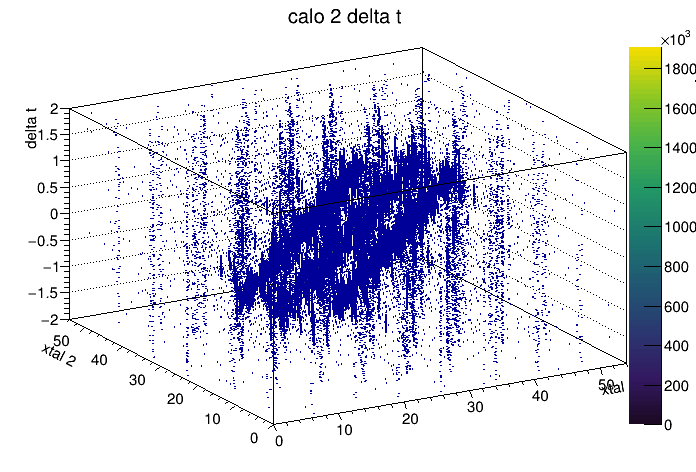

In [5]:
c = r.TCanvas()
h.Draw("lego2z")
c.Draw()

---

### Lets calculate the values for the matrices in each calorimeter

In [6]:
#useful helper functions

#converts xtal number into x/y position in calorimeter and vice versa
def xtalNumToPosition(x, y = np.nan):
    #if we are given two values, convert xtal position in calo to xtal number
    if(y is not np.nan):
        return x + y*9
    else:
        return (x % 9, int(np.floor(x/9)))

#returns the neighboring crystals in a grid in the form of an iterator
def ReturnNeighbors_NoDiagonal(x, y):
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (((i, j) != (x, y)) and i < 9 and j < 6 and i > -1 and j > -1):
                #print(np.abs(i-x) + np.abs(j-y), i, j )
                if(np.abs(i-x) + np.abs(j-y) < 2):
                    yield (int(i), int(j))

In [7]:
#this crystals deltaT value will be set to 0 as a reference in all calorimeters
xtalToFix = 0

In [8]:
#xtals which are dead or should otherwise just be set to 0
skipXtals = [
    (15,2),
    (11,18)
]

In [9]:
allDeltaTHist = r.TH1D("allDeltaTHist","All Delta T Values for Adjacent Crystals; Delta T [c.t.]; N",
                      1000,-2,2)

Starting calo 1
Starting calo 2
Starting calo 3
Starting calo 4
Starting calo 5
Starting calo 6
Starting calo 7
Starting calo 8
Starting calo 9
Starting calo 10
Starting calo 11
     Bad xtal 18
     Bad xtal 18
     Bad xtal 18
Starting calo 12
Starting calo 13
Starting calo 14
Starting calo 15
     Empty Fit Data in xtal pair 1 / 2
     Empty Fit Data in xtal pair 2 / 1
     Empty Fit Data in xtal pair 2 / 11
     Empty Fit Data in xtal pair 2 / 3
     Empty Fit Data in xtal pair 3 / 2
     Empty Fit Data in xtal pair 11 / 2
Starting calo 16
Starting calo 17
Starting calo 18
Starting calo 19
Starting calo 20
Starting calo 21
Starting calo 22
Starting calo 23
Starting calo 24


Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 


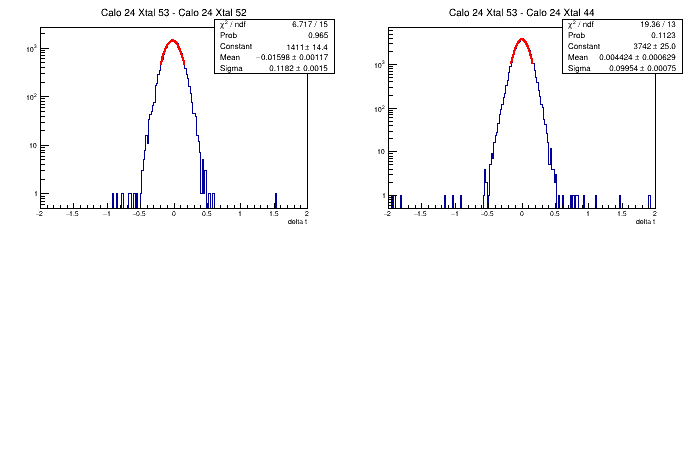

In [10]:
shape = (1,54) #shape of each row in the calorimeter matrix
caloMatrices = []

allChiSquareNDF = []
allN = []

allMeans = []
allCalos = []
allXtals = []

#for calo in [11,15]:
for calo in range(1,25):
    print("Starting calo", calo)
    
    #get the histogram for this calo
    h = f.Get("neighboringCrystalsDeltaT/hitDeltaT"+str(calo-1)).Clone("h_"+str(calo))
    h.SetDirectory(0)
    
    #create a matrix in which to store the xtal values and the deltaT value
    matrix = np.zeros(shape, dtype=float)
    rhs = np.zeros((1,1),dtype=float)
    #print(matrix)
    #print(rhs)

    takenPairs = [] #use this to avoid processing pairs like (1,0)/(0,1) twice. Just saves time.
    for xtal in range(54):
    #for xtal in [18]:
        adjXtals = [] #holds histograms from xtals adjacent to xtal
        c = r.TCanvas()
        c.Divide(2,2)
        i = 0
        #loop over the crystals which neighbor the reference xtal
        for x2, y2 in ReturnNeighbors_NoDiagonal(xtalNumToPosition(xtal)[0],xtalNumToPosition(xtal)[1]):
            c.cd(i+1)
            xtal2 = xtalNumToPosition(x2,y2) #convert positions in the caloriemter into an xtal number
            
            #get and draw the deltaT histogram for this pair of crystals
            bin_xtal = h.GetXaxis().FindBin(xtal)
            bin_xtal2 = h.GetYaxis().FindBin(xtal2)
            h.GetXaxis().SetRange(bin_xtal, bin_xtal)
            h.GetYaxis().SetRange(bin_xtal2, bin_xtal2)
            hi = h.Project3D("z").Clone("h_"+str(xtal2))
            hi.SetTitle("Calo "+str(calo)+" Xtal "+str(xtal)+" - "+"Calo "+str(calo)+" Xtal "+str(xtal2))
            allDeltaTHist.Add(hi)
            allN.append(hi.GetEntries())
            adjXtals.append(hi.Clone("h_"+str(xtal2)))
            adjXtals[i].Draw()
            r.gPad.SetLogy()

            #calculate the mean and weight of the deltaT histogram
            mean = hi.GetMean() #initial values, later changed to values from gaussian fit
            weight = 1
            
            #fit the deltaT histogram using a gaussian. We can play with the range here to ensure good fits.
            func = r.TF1("func","gaus",-10,10)
            func.SetParameters(1,mean,0.3)
            for ieunerin in range(2):
                adjXtals[i].Fit(func,"REMBQ","", mean-0.5, mean+0.5)
            sigma = func.GetParameter(2)
            mean = func.GetParameter(1)
            func.SetParLimits(1,mean-0.5, mean+0.5)
            adjXtals[i].Fit(func,"REMBQ","", mean-1.5*sigma, mean+1.5*sigma)
            
            #from the fit, calculate new values of the mean/weight
            try: #if the fit worked (i.e. the histogram was not empty) this should succeed
                allChiSquareNDF.append( func.GetChisquare() / func.GetNDF() )
                if(func.GetChisquare() / func.GetNDF() < 50 and (calo, xtal2) not in skipXtals):
                    #mean = hi.GetMean()
                    #weight = hi.GetRMS()
                    mean = func.GetParameter(1)
                    #weight = func.GetParameter(2)
                    weight = func.GetParError(1)
                else:
                    print("     Bad xtal", xtal2)
                    
            except:
                allChiSquareNDF.append(0)
                #print(mean,weight)
                print("     Empty Fit Data in xtal pair", xtal, "/", xtal2)
                
            #save some values for verification plots later
            allMeans.append((mean,weight))
            allXtals.append((calo-1)*54 + xtal)
            allCalos.append(calo)
            #print(mean,stdev)

            #create a new row in each of the matrices and set the values accordingly
            newMatrixRow = [[0 for i in range(54)]]
            if((xtal == xtalToFix) or ((calo,xtal) in skipXtals)):
                #print(calo,xtal)
                #this being set to a very large number effectively fixes the constant for this xtal at 0
                newMatrixRow[0][xtal] = +10000000
                newRHS = [[0]]
            else:
                newMatrixRow[0][xtal] = +1/weight
                newRHS = [[mean/weight]]
                newMatrixRow[0][xtal2] = -1/weight 
            #print(newMatrixRow)

            #append these rows to the existing matrices and update the pairs which have been processed
            if( (xtal, xtal2) not in takenPairs and (xtal2, xtal) not in takenPairs ):
                matrix = np.append(matrix, newMatrixRow, 0)
                rhs = np.append(rhs, newRHS, 0)
                if(xtal != xtalToFix):
                    takenPairs.append((xtal,xtal2))
                
            i+=1

        #hi.Draw()
        c.Draw()
        #c.Print("./images/deltat/DeltaT_Calo_"+str(calo).zfill(2)+"_Xtal_"+str(xtal).zfill(2)+"_Xtal2_"+str(xtal2).zfill(2)+".png")

    #delete first placeholder row of all zeros from the matrices
    matrix = np.delete(matrix, 0, 0)
    rhs = np.delete(rhs, 0, 0)
    
    #add to running list of matrices for all calos
    caloMatrices.append((calo, matrix, rhs))

---

### Some verification plots for the fits

Mean DeltaT: 1.2180742908016134e-07


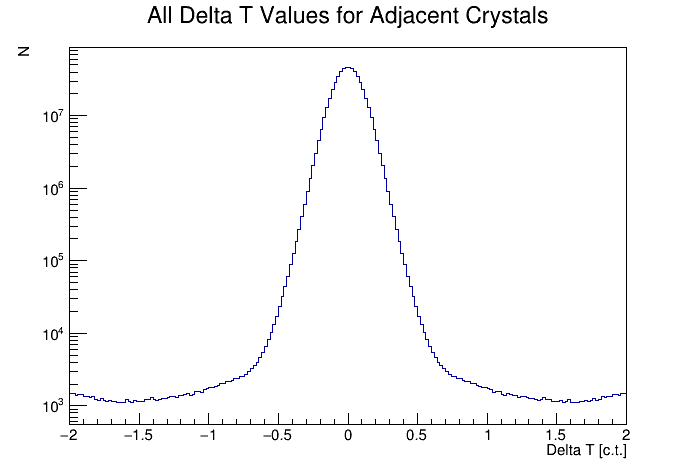

In [11]:
c = r.TCanvas()
allDeltaTHist.Draw()
print("Mean DeltaT:", allDeltaTHist.GetMean(1))
c.SetLogy()
c.Draw()

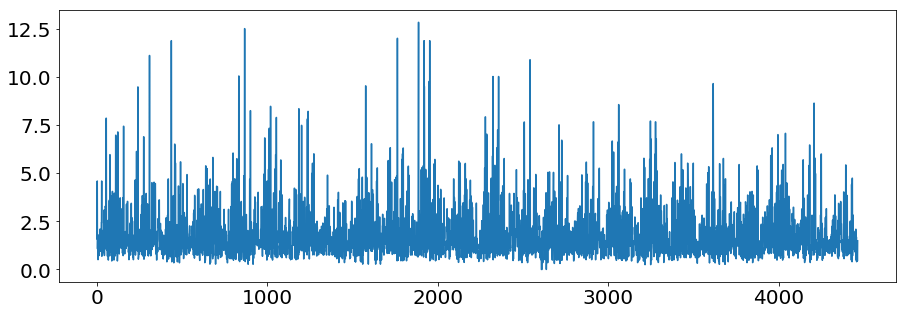

In [12]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(allChiSquareNDF)
#plt.plot([0,len(allChiSquareNDF)], [10,10])
plt.show()

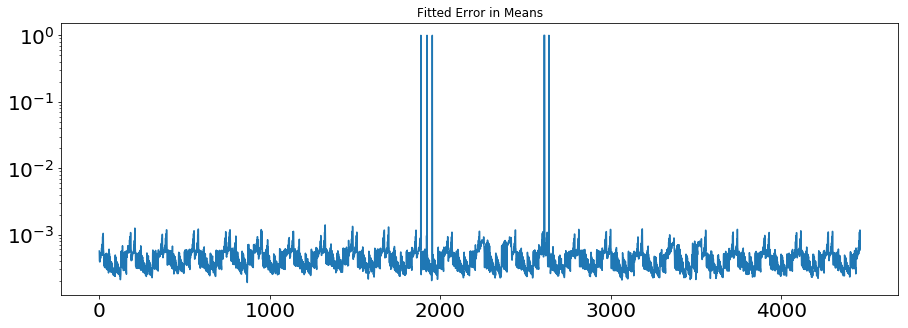

In [13]:
means, stdevs = zip(*allMeans)

fig,ax = plt.subplots(figsize=(15,5))

plt.plot([y for x,y in allMeans])
#plt.plot([0,len(allChiSquareNDF)], [10,10])
plt.title("Fitted Error in Means")
plt.yscale("log")
plt.show()

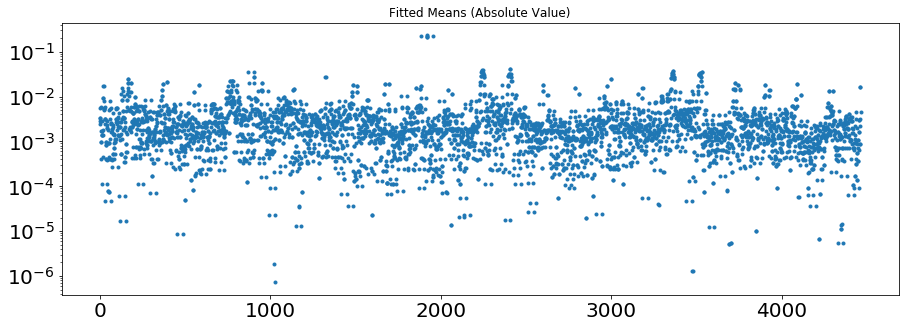

In [14]:
means, stdevs = zip(*allMeans)

fig,ax = plt.subplots(figsize=(15,5))

plt.errorbar([x for x in range(len(means))], np.abs(means), yerr=0, fmt=".")
#plt.plot([0,len(allChiSquareNDF)], [10,10])
plt.title("Fitted Means (Absolute Value)")
plt.yscale("log")
plt.show()

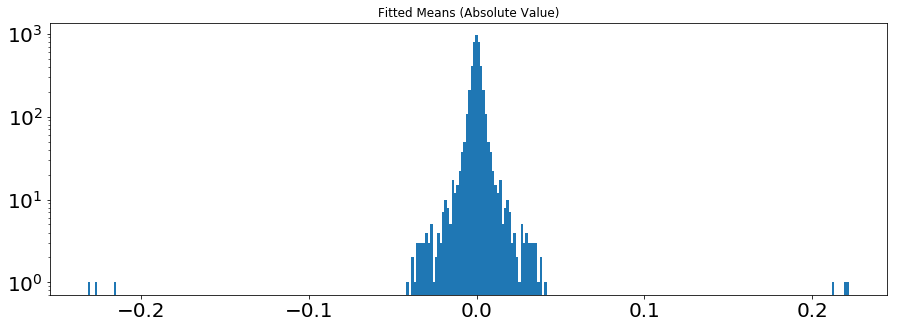

In [15]:
means, stdevs = zip(*allMeans)

fig,ax = plt.subplots(figsize=(15,5))

plt.hist(means,bins=80*4)
#plt.plot([0,len(allChiSquareNDF)], [10,10])
plt.title("Fitted Means (Absolute Value)")
plt.yscale("log")
plt.show()

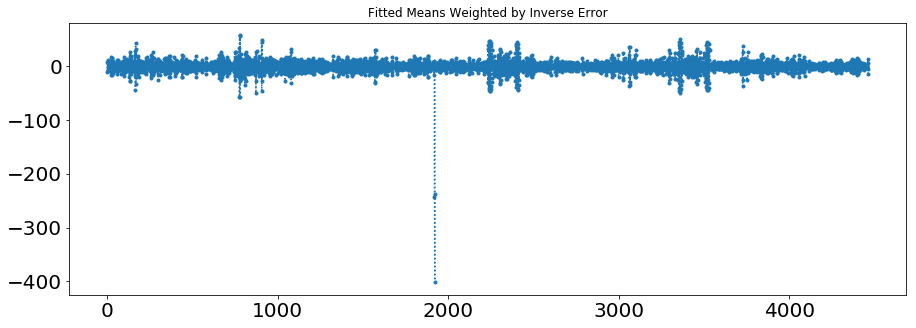

In [16]:
fig,ax = plt.subplots(figsize=(15,5))

plt.errorbar([x for x in range(len(means))], [x/y for x,y in allMeans], yerr=0, fmt=".:")
plt.title("Fitted Means Weighted by Inverse Error")
#plt.yscale("log")
plt.show()

/home/jlab/anaconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


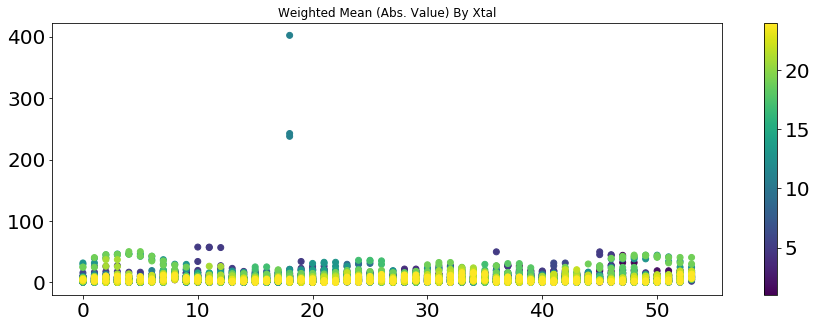

In [17]:
fig,ax = plt.subplots(figsize=(15,5))
plt.scatter([x%54 for x in allXtals], [np.abs(x/y) for x,y in allMeans], 
            c=allCalos, 
            vmin=1,
            vmax=24
           )
plt.colorbar()
plt.title("Weighted Mean (Abs. Value) By Xtal")
plt.show()

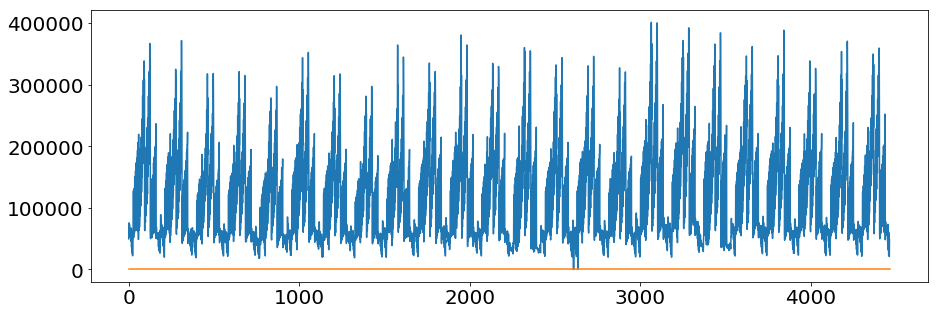

In [18]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(allN)
plt.plot([0,len(allChiSquareNDF)], [100,100])
#plt.ylim(0,250)
plt.show()

---

### Now lets take a look at the matrices we generated

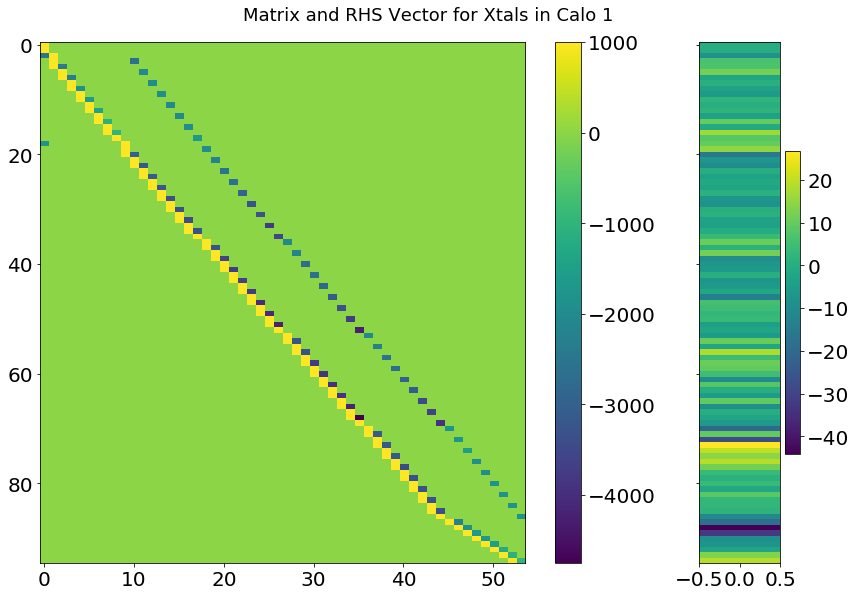

In [19]:
fig,ax = plt.subplots(1,2,figsize=(12,8), gridspec_kw={'width_ratios': [6, 1]}, sharey=True)
calo = 1
im = ax[0].imshow(caloMatrices[calo-1][1],
           #norm=matplotlib.colors.LogNorm(), 
           #vmin=-20, 
           vmax=1000,
           aspect='auto')
im2 = ax[1].imshow(caloMatrices[calo-1][2],
           #norm=matplotlib.colors.LogNorm(), 
           #vmin=-20, 
           #vmax=20,
           aspect='auto')
plt.colorbar(im, ax=ax[0])
plt.colorbar(im2, ax=ax[1])

plt.suptitle("Matrix and RHS Vector for Xtals in Calo "+str(calo), y=1.03, fontsize=18)
plt.tight_layout()

plt.show()

---

### Now lets solve for the timing constants for each calorimeter.

We do this suing singular value decomposition. This can be accomplished using a number of tools, but we will use numpy's lstsq (and scipy's lsq_linear as a cross check)

In [20]:
#now lets do the SVD using numpy
#    see: https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html
caloSVD = []
from scipy import optimize

for calo, matrix, rhs in caloMatrices:
    if(False): #use least squares method from numpy
        timeConstants, residuals, rankOfMatrix, singularValuesOfMatrix  = np.linalg.lstsq(matrix, rhs)
        timeConstants = timeConstants*-1 #invert calculated values to agree with conventions
        caloSVD.append( (calo, timeConstants, residuals, rankOfMatrix, singularValuesOfMatrix) )
    else: #use least squares from scipy
        rhsVec = np.ndarray.flatten(rhs)
        timeConstants = scipy.optimize.lsq_linear(matrix, rhsVec)
        caloSVD.append((calo, timeConstants['x']*-1, timeConstants))

/home/jlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [21]:
print([x[0] for x in caloSVD])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


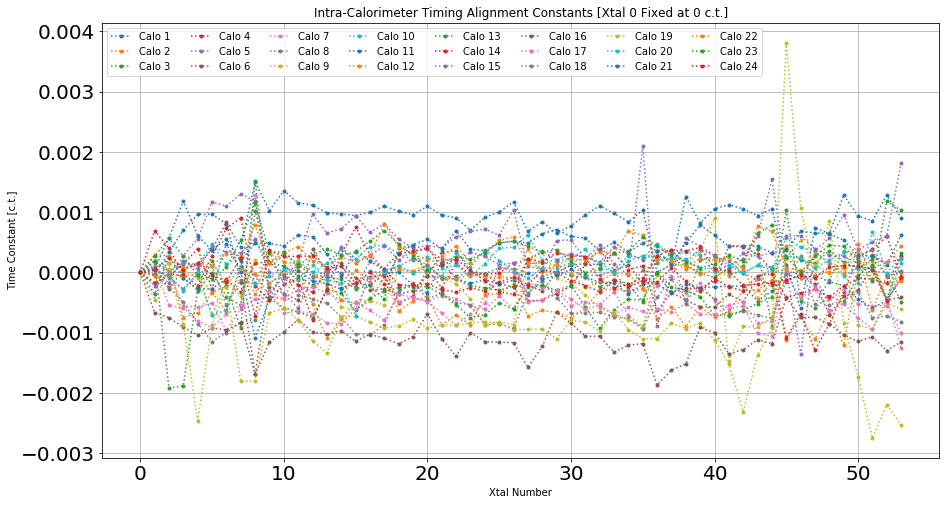

In [22]:
fig, ax = plt.subplots(figsize=(15,8))
#plt.ylim(-0.3,0.6)
for calo in range(24):
    plt.plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Calo "+str(calo+1))
plt.legend(ncol=8)
plt.title("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]")
plt.xlabel("Xtal Number")
plt.ylabel("Time Constant [c.t.]")
plt.grid()
plt.show()

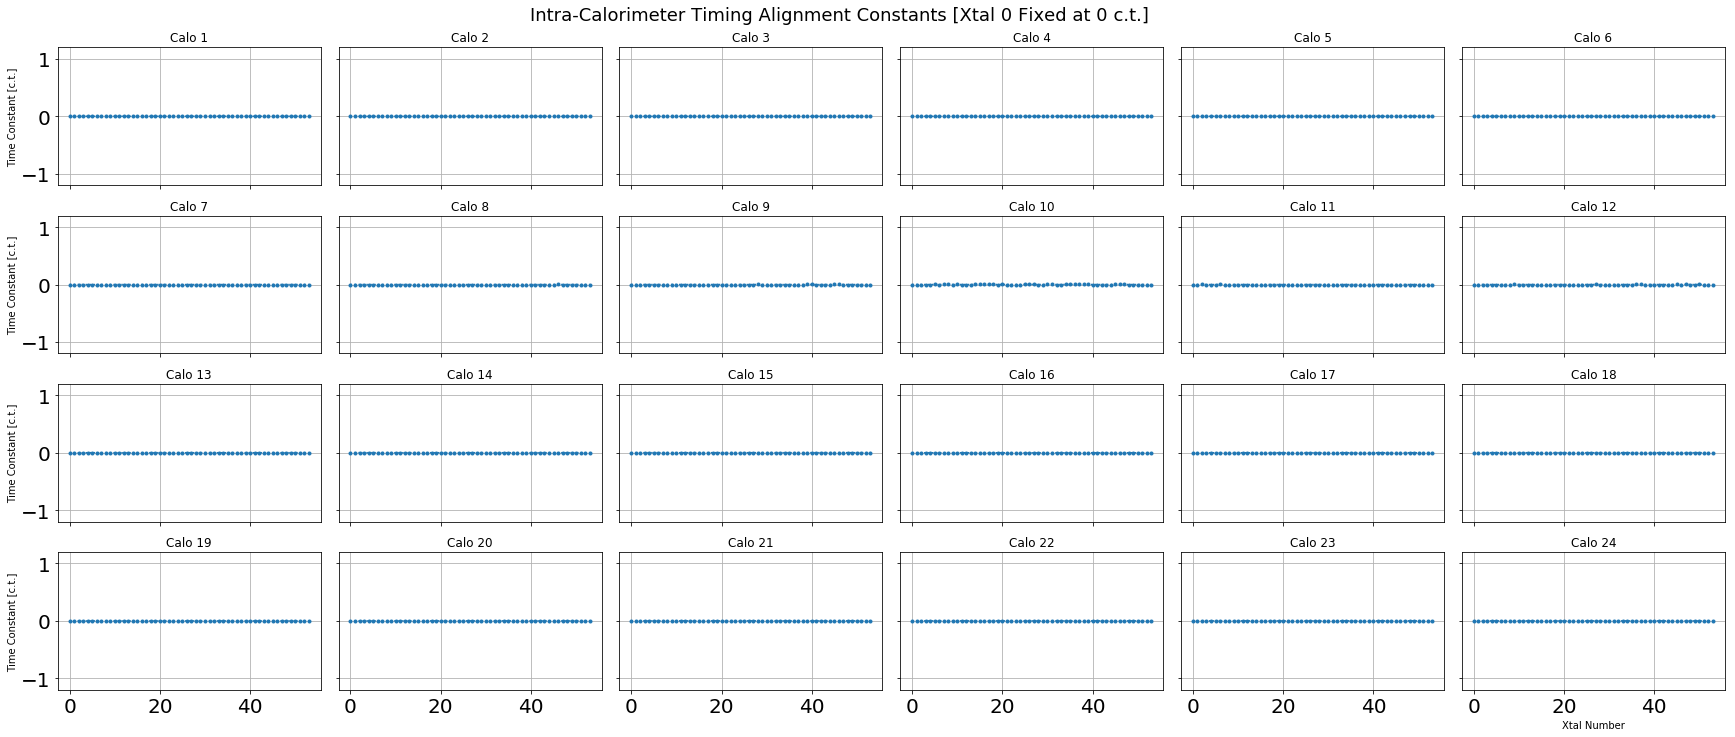

In [23]:
fig, axs = plt.subplots(4,6,figsize=(25,10), sharex=True, sharey=True)
#plt.ylim(-0.3,0.6)
ax = flatten2dArray(axs)
for calo in range(24):
    ax[calo].plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Calo "+str(calo+1))
    ax[calo].set_title("Calo "+str(calo+1))
    ax[calo].grid()
    if(calo % 6 == 0):
        ax[calo].set_ylabel("Time Constant [c.t.]")
#plt.legend(ncol=8)
plt.suptitle("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel("Xtal Number")
plt.tight_layout()
plt.ylim(-1.2,1.2)
plt.show()

---

### Now lets compare with the values calculated by Jasons macro with the same parameters

For his constants, the value of xtal 0 is fixed

In [24]:
#print([list(caloSVD[calo][1]) for calo in range(24)]) 
myConstants = [[-6.423170697987329e-17, -0.035042732574085356, -0.13576100689835643, 0.16432687407623975, 0.029844563141044132, -0.037116181753003616, 0.3565245032178923, 0.3678944185184505, 0.324793200019928, -0.11179057780718665, -0.06725398937375981, -0.24103338820361686, 0.04338739705398259, 0.05417296964728946, -0.022662575162507137, 0.37437269212977964, 0.2520137997816961, 0.1890153948525958, -0.1106378715885947, -0.11881385544164452, -0.13967374114797737, 0.03638129852020672, -0.024155767512795218, -0.005940911195498777, 0.3198576173909549, 0.30847584019892055, 0.2444062983933266, -0.09121605301789162, -0.21606989908384533, -0.20143671135927044, 0.130684275368188, 0.05387447369551198, -0.05562226269193199, 0.3743730877167051, 0.2959736990559508, 0.33429962863979307, -0.100787052108553, -0.233631593297725, -0.3237244697094972, 0.2132582795736986, 0.055335482956038004, -0.020349657635294817, 0.4144755939545426, 0.23609462008647122, 0.23465255074205676, -0.04823749673989776, -0.1004769041962039, -0.04702139015671849, 0.0821732766428922, 0.03712715431961582, 0.04302798073263575, 0.31289845041606895, 0.3075669671655483, 0.2514319157318246], [-3.2896587991546586e-16, 0.02960760770859769, -0.08748921803909658, 0.2387086461103512, 0.17365653560644892, 0.17958486825113573, 0.5516802012691024, 0.41778124496574687, 0.39666885822913006, 0.021872233974674526, -0.010070869496763946, -0.08274670709077148, 0.2617234383999214, 0.18338123041569887, 0.0912707143688779, 0.5183544301858802, 0.40102787703384446, 0.3971317700661693, 0.01781990624358326, -0.05227713298732306, -0.0665351539102689, 0.3077372433413179, 0.18091984945610912, 0.23194304982687894, 0.46619625319619157, 0.564075313496739, 0.35274633183379517, 0.04521788529184617, 0.0336524794245599, -0.1813283852535066, 0.32380073422496564, 0.2212488730865533, 0.20578856389380856, 0.5090736451750926, 0.442288586834016, 0.4913888597863278, 0.021160043228964726, 0.046143457614177485, -0.14154133530866153, 0.324473788001275, 0.2212892383346658, 0.20681075112895503, 0.5616317292609243, 0.43005189739093747, 0.3007220841027006, 0.13055043252253007, 0.054680089695993715, -0.04945612051481277, 0.3574693860949373, 0.2469146814127234, 0.19734917229582835, 0.49715874691578554, 0.4783980633815808, 0.41592759325592976], [-5.778452130834679e-16, -0.03795605950552908, -0.23477637884287347, 0.13606949277013103, 0.09430607375058424, 0.11091231513355189, 0.4605909706298979, 0.47317354510144893, 0.3191590532972373, -0.01313207066355998, -0.17738971985265672, -0.2695140048413898, 0.07617063596033108, 0.04437564376874176, 0.035337057022328366, 0.4653763782662103, 0.3978192345653495, 0.31965157739491495, -0.037178477846240676, -0.1552797994409839, -0.10003957163438232, 0.057513020108936885, -0.02877962285395294, 0.028487653492818732, 0.3675530639796526, 0.4169171778495052, 0.35370391282167657, 0.012862083681258074, -0.17062559411527273, -0.25043951429092914, 0.18765230978182265, 0.08433377089867214, 0.003077412039050348, 0.36286789554263543, 0.3270935740415306, 0.33842229115901323, -0.00928462186055308, -0.10959109406324873, -0.21270664244574178, 0.10323814774818107, 0.04458657714389484, 0.0896704441551774, 0.36860261090148627, 0.3720485249729766, 0.3547222437765374, -0.0386043200352942, -0.12325249978198236, -0.24082017165982328, 0.15996696328291993, 0.07574669544546542, -0.03108872941237706, 0.346754589325826, 0.34300045529759865, 0.30647989100553114], [-2.6457901988954964e-16, -0.002811637440464247, -0.07875511698357367, 0.24058964920294112, 0.20472202548757473, 0.17418291867441754, 0.4501716124718329, 0.4176253189273675, 0.3524824027521861, -0.038626456262103204, -0.07506515013186199, -0.11578265465989235, 0.149958551201744, 0.2115321980848318, 0.03789501112482485, 0.4911605882073965, 0.31552407680648575, 0.2974368231416778, -0.08404079349712956, -0.09575792297081753, -0.12590772754612745, 0.1697464367323896, 0.13619831040708624, 0.03602824375346231, 0.3217760674342981, 0.3817620017441822, 0.2894255745669123, -0.10333279602348636, -0.030097613435887294, -0.14646937949348265, 0.1472342380963677, 0.18053703121650805, 0.06027494630148873, 0.48374944911217965, 0.42726146218152855, 0.25345906126819695, 0.08675647289692914, -0.10872223941426551, -0.21410469340872712, 0.12976006482002117, 0.15088669408341637, 0.08768889545927643, 0.488369218979362, 0.3382901482625201, 0.3401947594228898, -0.00034430880547017817, -0.09979317405404153, -0.16226577540962725, 0.18977546388471145, 0.10958002223810856, 0.12650247100723933, 0.5107494414721764, 0.41376424220553665, 0.3552878464875393], [4.881677812240147e-16, 0.019114504244212176, 0.34026407482513615, 0.2963411009882484, 0.3282334135542145, 0.6355209304297613, 0.42625501700416674, 0.5032106691131131, 0.36398992854579576, 0.04776817144411194, 0.04867511325935048, 0.07923897000861313, 0.359671737601179, 0.24162040726120593, 0.03814735853438522, 0.39588936966428345, 0.34623759864099857, 0.38454785877829994, 0.05353091432687379, -0.060649480206336204, -0.11944394759758367, 0.24334417476667325, 0.19065361790245824, 0.4394350915731599, 0.48229127155432006, 0.42050655282999805, 0.3374468610714097, 0.12190693169368888, -0.0389025222797342, -0.14770432801876826, 0.21538718992377814, 0.19253001864489705, 0.19004174886257014, 0.45126762431341244, 0.37944296773565594, 0.3087543305651014, 0.03535909250275383, -0.008131895685089666, -0.07818857854673678, 0.23813795922972503, 0.19852910570245658, 0.26888949480010294, 0.45114067441605654, 0.3801284433692854, 0.3632950545990702, 0.07372201294650786, 0.15723824907513048, 0.28238376014322686, 0.29657417197904967, 0.24586285831146648, 0.5363677363351863, 0.4720778226667121, 0.4569400055263317, 0.4458119164679498], [-3.5847980774895153e-16, -0.4070849243421118, -0.5318853121893521, 0.017608251761389027, -0.10154698169869003, -0.22055142181802373, 0.1586751484085983, -0.0884652006512534, -0.12842974468398127, -0.10691463254253741, -0.5039171741770997, -0.6552256008550421, -0.19829148818288156, -0.19235431366551717, -0.1827944646847755, -0.14767201246788447, -0.17185381778235936, -0.2420153586949675, -0.490008528619477, -0.5091006820839102, -0.6969075347963266, -0.10447416562264948, -0.20667178156754445, -0.3309997220712183, -0.07270875780742386, -0.15337270952513102, -0.15472311955575455, -0.4778714019250804, -0.5639219637180193, -0.5582999164283003, -0.07406393823142696, -0.14112332165492056, -0.18577612274984687, -0.09358349147448242, -0.10881607648937686, -0.21454481638867104, -0.5128228812922633, -0.5994350020896595, -0.5995643272626604, -0.11649772658305485, -0.2559721967123234, -0.23956724566499998, 0.05811962475440628, -0.19226475339161958, -0.19601401043663014, -0.46344275315093975, -0.5197300117476935, -0.5737177499858115, -0.09869613332792782, -0.08768352652403238, -0.21339954601252956, -0.02272621708060313, -0.08981522312521395, -0.16783831343833502], [-8.783111880757018e-17, -0.002382846128585858, 0.03608191907590759, 0.30769020957436594, 0.1560351436414366, 0.1524036907898378, 0.6355449752271839, 0.5210150605693072, 0.3741732205026408, 0.057163763205841045, 0.004513660450967127, -0.17432635862903745, 0.33104813107139086, 0.19027477391809966, 0.0421016452947518, 0.49069399036468125, 0.42714146893319394, 0.34625936073505503, 0.032988322444040485, -0.054979779280051266, -0.12258273792848151, 0.2505271561489467, 0.21187150549542047, 0.12900524574235495, 0.445456744686961, 0.43065971823444227, 0.3589043106200241, 0.07466906987737837, -0.027905291217364625, -0.16686880872619322, 0.26314835397446246, 0.18994597609535596, 0.17631311669774574, 0.5081892832222741, 0.3803887678875028, 0.39105828812194615, 0.10859167377790761, -0.06279081627591374, -0.10658037682948823, 0.1677041680148804, 0.11312079088666267, 0.0341594654920927, 0.49691101462143045, 0.3402742347109836, 0.34796562357992433, 0.03824956719667466, -0.025410752938110598, -0.07044759889301727, 0.30156079331630087, 0.22112124131200217, 0.13464339089778418, 0.4892532473842083, 0.4774259964638073, 0.37345423070582795], [-1.218659329277662e-16, -0.10868919058757032, -0.19804932710460782, 0.2218535848472354, 0.14252952869740187, 0.04518225594731001, 0.4214286977526742, 0.4011713605396578, 0.2575908448991568, -0.04369342936426268, -0.1047384346501738, -0.1556123556376122, 0.17644877602521686, 0.16612531348907145, 0.046864586650344875, 0.4044057132704022, 0.41231180163228975, 0.2667798766818359, -0.03146340309524784, -0.1835230081780651, -0.22809584784827613, 0.06862686804889814, 0.15760368471917524, -0.06867430511949085, 0.3720017767497663, 0.28201229365047054, 0.2542790063253919, 0.0021872755797785193, -0.13574330422449926, -0.12831299458040665, 0.15411600499012354, 0.05612419934707624, 0.020492602345885843, 0.3171876832616136, 0.3148077404626374, 0.1873101006931488, -0.007860917137803403, -0.15798792051087387, -0.20269114344328729, 0.11515957118239117, 0.035632396215944995, -0.0513687545813854, 0.3197232939482816, 0.28443196486812083, 0.11218006543548509, 0.029130087631227035, -0.15169261613117982, -0.1732221174176899, 0.13736773973031932, 0.016388805530160963, 0.42440100664181873, 0.4242012054301955, 0.4317080654648132, 0.3502729791721898], [-5.52663038877279e-16, 0.06356419128974564, -0.1473642397169317, 0.28322303245820635, 0.2024141217542824, 0.0498362865765376, 0.4236945425255243, 0.41865834329926127, 0.42842915400265, -0.014434104098476008, -0.016356131222747705, -0.08612500938051393, 0.1941302907372353, 0.171900595102907, 0.08927755318282365, 0.5240470387069694, 0.2841814443321502, 0.27962899580354345, -0.08282754723661961, -0.1579669336985739, -0.08682204886978359, 0.2160504649011718, 0.11542738893456161, 0.04444487443930478, 0.575195218949745, 0.3544772724990233, 0.34460766395105924, -0.12175951085384122, -0.054151720795551916, -0.14619954612117866, 0.22483979622605937, 0.15627590277461828, 0.12757844710271354, 0.444271282250651, 0.38334285826373743, 0.26355447661105635, -0.07746821870038212, -0.04486474093430172, -0.10626004644049628, 0.2038721959582589, 0.07918954082558713, 0.21077623032877058, 0.30980696461067625, 0.38117598316221557, 0.33972520377003235, 0.04495931981961037, -0.0499216354877135, -0.11002086574855621, 0.28771692020960316, 0.2520921483048181, 0.18925549115023615, 0.5187184451709983, 0.47327568238102424, 0.3797909506047138], [-3.924766913619579e-16, -0.05690684723600048, -0.1797222221194511, 0.18604410193271825, 0.07875239840761504, 0.06507136643152397, 0.31833318864153826, 0.3151898405059563, 0.3104422886884945, -0.06462031264574514, -0.21694688215165042, -0.21497680746800252, 0.16682411203991626, 0.049256732818308446, -0.030375370024038395, 0.3056653691315312, 0.2564682674550425, 0.20893903644975317, -0.039729748631063155, -0.06514218496549784, -0.20315694930534323, 0.09541403723317812, 0.07522803099518319, -0.022964372036161196, 0.26413398352482453, 0.3111561187631523, 0.20295937856119556, -0.08516893516764362, -0.18115238547795753, -0.21266296896951153, 0.18642727428867076, 0.06797169580212502, -0.04414190149865724, 0.4146189987188213, 0.3078500355590683, 0.24765663522459752, 0.08656870906122638, -0.20678378023574692, -0.1927963533070794, 0.13887173316695675, 0.09817734946098763, -0.07376747686305454, 0.2952438599126831, 0.232562430810521, 0.15286736141944318, 0.05418499597804456, -0.05545314047336191, -0.14535831015409487, 0.12897764706367354, 0.058246334136026125, -0.059208912485260945, 0.34484420057811904, 0.3476812553249624, 0.28983231958628664], [2.145496531445163e-15, -0.10029901446060081, -0.15169325208788986, 0.17542715735360634, 0.1347775781880049, 0.16221279937881972, 0.48724307145393436, 0.43573541325208964, 0.42232907542775755, 0.047335910825283045, -0.003478638040257942, -0.1622332267135389, 0.17921177338523908, 0.1332061670310093, 0.1065397690706994, 0.4636857005405944, 0.38765357782898424, 0.37177083380764925, -2.275957200481571e-15, -0.06751682219051833, -0.21693550012326568, 0.17932948159271248, 0.11050045258397428, 0.08223581672876878, 0.42311215123521695, 0.387740642098543, 0.35833501553758795, 0.02119338932085521, -0.0477826264405265, -0.14270345529052897, 0.21524524975414466, 0.1311836126856529, 0.044029442585801826, 0.44906855332571355, 0.3600806204837274, 0.3929723972353968, 0.004480917210327347, -0.057497636283979844, -0.10832545765263013, 0.20816911915152547, 0.20141181395723523, 0.05554943358770881, 0.4896074762859595, 0.3643980945234036, 0.34289662963015777, 0.15491571039476984, -0.01213040185841683, -0.11071382251157873, 0.25460588294659475, 0.1634457005455524, 0.08410201076115609, 0.5265885063581308, 0.4726165067332609, 0.4337458960398764], [-8.079349819664193e-17, -0.1440346242286912, -0.27200400380674805, 0.12650307800716817, 0.10525949722706118, 0.0933977612005962, 0.40031540285001616, 0.3387067578187268, 0.3033821942530807, -0.15982084373289757, -0.1926989070482756, -0.2537135341240509, 0.17255952649990264, 0.021164604398314246, 0.032157467447506805, 0.2899871090388341, 0.2926832456248502, 0.24972409303625048, -0.08735999786572099, -0.17201089676379025, -0.22259575806024928, 0.08997620760868735, 0.04583435865579441, 0.021732983848554988, 0.24400299315563756, 0.21980521951338766, 0.16473116975471278, -0.1560433867016989, -0.22698402910340015, -0.31543059649364585, 0.08019437931541543, 0.04637790508476179, -0.05831368458447053, 0.35162510079902776, 0.33386392130078324, 0.1856936226193432, -0.138059737702995, -0.09937659681243816, -0.26012093876333986, 0.11154965746792246, -0.042078594952134146, 0.018438511882762604, 0.3658576008370129, 0.23912107523104048, 0.2205343590976826, -0.10959664771648173, -0.10642254964379627, -0.229728561950512, 0.054982721301225605, -0.01126466684837809, -0.07857926011840036, 0.38888790456396644, 0.3154780088552428, 0.14958421266554794], [5.570259010612365e-16, -0.06660009535663292, -0.02899502803052333, 0.3695233272758837, 0.2847883704115713, 0.2038456363997917, 0.513619280034878, 0.454090546006809, 0.41126303293911187, -0.0009000407329129434, 0.021450825810840235, -0.11409549113461331, 0.2900335215311824, 0.1661660075134258, 0.10781828856963349, 0.5135415648688331, 0.42766221658155473, 0.40134868963898374, 0.1259344009554057, -0.0716430728897739, -0.04998744841589514, 0.3057632618377213, 0.16088526953534243, 0.09569287597179255, 0.49794100472570624, 0.4064075908724056, 0.3576493846418509, 0.01907433013068832, -0.013967770817934433, -0.14834089376067605, 0.24693463350146339, 0.1143374049327685, 0.1208964911581121, 0.5349059694813361, 0.4425021777856354, 0.3789459442781608, 0.024275438097223608, -0.020267369849538176, -0.150456097744783, 0.2469154612301459, 0.19910669911993834, 0.18709566570080013, 0.4717386845751955, 0.44943779757098223, 0.3738773492460748, 0.0844751977926255, 0.03387209922670899, -0.058231652704629225, 0.3479149654977215, 0.33042471383469263, 0.14920557646472982, 0.5364435047235463, 0.523728439049499, 0.48643336301612045], [1.0641394823734983e-15, 0.00930665339819944, 0.7301823109517109, 0.323485255318827, 0.1707574274108214, 0.10188263620471599, 0.4530305624996216, 0.4902975068795573, 0.4309676007172754, -0.008885302607705925, -0.018602341625271746, 0.2903702656348721, 0.21955530201947526, 0.11107114785817396, 0.06658385303307368, 0.4977205286280175, 0.3929838221754217, 0.3696276468298309, -0.007009120849816364, 0.008529151123414902, -0.1016800854263684, 0.6652114205282565, 0.22343147680245837, 0.08886004775925538, 0.4868020108430021, 0.4391096554378689, 0.39016178402702506, -0.01322402537040046, -0.06595792362585169, -0.1881069468473002, 0.2655548683547815, 0.09773173414407027, 0.1209783190218516, 0.4590881929914086, 0.41474768121634453, 0.3562014424482798, -0.012926622008265942, -0.048876351641189725, 0.6192996198495324, 0.28323658324627504, 0.12682119755802046, 0.11948910116614753, 0.5750244425519015, 0.31404749836195517, 0.4076835658133714, 0.07589849008544163, -0.10420495883577774, 0.7798502835543185, 0.28525879645846286, 0.1980736940211351, 0.15938246230274844, 0.5094668073907717, 0.47674354274481123, 0.37495246594951614], [3.6553467187847566e-16, -0.11608877031036102, -5.273559366969494e-16, 0.17732954324577507, 0.07675178611056512, 0.015409768652695693, 0.43166030464240757, 0.3618127484698409, 0.21240713973851325, -0.03378780906874271, -0.15439317078348075, -0.1588431355099792, 0.04489476637029183, 0.07688423841658323, 0.046346428593049105, 0.3460430925078909, 0.30183337974917157, 0.19594651892121212, -0.0727524278852581, -0.19385429269441407, -0.1943439921254672, 0.06581346112716849, 0.06264169649189415, -0.014288864674214141, 0.3606931140213992, 0.3275751739652356, 0.20822386552029723, -0.013680704321493486, -0.17219865085815136, -0.22289187801047122, 0.12290995423870821, 0.027247290966220417, -0.0504660519350045, 0.3735346312084812, 0.27584512105797304, 0.21759623731117408, -0.026469707378655376, -0.09755366767114804, -0.20419688353055782, 0.09854535928402786, 0.042734894033792825, 0.04158847832860371, 0.29705493700985625, 0.3200700866218178, 0.36442588794766734, 0.0027025579341390105, -0.06354617929185195, -0.222633886456339, 0.21328498486154018, 0.12852109963440017, 0.04288434458867668, 0.4462352944540179, 0.40127654920892963, 0.33193563956956285], [8.665889166612328e-16, 0.030099458561920978, 0.7437427435463086, 0.2132362672189937, 0.17426907729524482, 0.1382101351590314, 0.4889062051036687, 0.46577109581547405, 0.42572265598826814, 0.01417896793504736, -0.04262263704193281, -0.10003852974703764, 0.2097046272736416, 0.5448060459951056, 0.2029493667904283, 0.5200916953257434, 0.36232177945971356, 0.3407686724141925, 0.05304594696573517, -0.05363773974764641, -0.1635680476422285, 0.16210208199412207, 0.07156721131217719, 0.02088307214407964, 0.4586551670740207, 0.25995363052157067, 0.2794535353556689, 0.06298990261798182, -0.0035201923698611054, -0.08997141760760596, 0.21719012881678082, 0.11087982530512297, 0.05096332734635038, 0.4345663073199185, 0.3027692473401634, 0.43435685033009663, 0.06256377670756094, -0.1318085604029347, -0.085446158557554, 0.14809189612282103, 0.13902493346031222, 0.08870812055475844, 0.39732497464405325, 0.31956197022332555, 0.2575331347443824, 0.0873176677156754, 0.006370990566169091, -0.05735720808288003, 0.3933181219848745, 0.18873068877099505, 0.1672941742943923, 0.4686651794816789, 0.49851036308050517, 0.39172579275022495], [1.3325333271258344e-15, -0.06742583052532654, 0.8210541123011323, 0.25742796512623867, 0.17671617680877594, 0.15770958298837023, 0.5054415440376311, 0.5248091785919328, 0.40796661084804065, -0.007414589792184123, 0.006870500175197636, -0.18434373416838234, 0.21780163353181214, 0.23776874878504184, 0.12064487076776298, 0.5153648055178743, 0.41093848600952765, 0.29716375997064826, -0.09102957265691963, -0.09616846827482023, -0.08519390317701497, 0.20260238178043846, 0.17096080372482556, 0.13818692098809213, 0.44212491171313806, 0.4977226999279574, 0.3006808033905678, -0.08919594375415923, -0.015775109069020743, -0.10633430767634856, 0.1949052775901179, 0.1430767265670599, 0.01785334644687231, 0.5306000712121124, 0.30987723097159897, 0.35061962696845694, -0.03153831621905012, -0.1066879142517734, -0.07646561031222038, 0.2536109004397521, 0.22190418428972689, 0.10650151725905602, 0.44899252750599505, 0.4361980690457405, 0.30035796701197864, 0.11545999173881273, 0.05085089979656049, 0.8010536549497267, 0.3545295516786621, 0.24799753930026136, 0.1800382742780362, 0.5549268631720581, 0.46521397690669897, 0.41995697686337424], [9.104755494253387e-16, -0.09565533441211913, 0.7263028757706427, 0.22116756285405387, 0.11922968365161729, 0.08120422637436664, 0.37966434312954317, 0.42126354231905894, 0.3625559921818644, -0.11363644017445607, -0.12170202620283638, -0.12342101779204184, 0.14709312919258627, 0.08933398325892278, -0.006938474439502629, 0.3689969464215447, 0.3618202100020711, 0.2803840348975498, -0.11093833538781728, -0.15147297009643007, -0.1951845897797956, 0.054109431270882274, 0.038435175164854674, 0.041834135778292036, 0.3709114818186019, 0.2792789220941568, 0.24071907740448567, -0.05961918065493854, -0.11218691338072179, -0.2228502274470521, 0.14462315264531095, 0.042266841501377043, -0.03970906331501556, 0.3739713833029542, 0.36309072575194357, 0.2986208192960357, -0.011114453029864885, -0.16584521574607233, -0.06255320233786979, 0.0689988332127428, 0.12163402224101066, 0.05465164700253189, 0.4205594451094949, 0.3363951543277206, 0.301160396374707, 0.031455070844394306, -0.03576953178978157, -0.16310718987180178, 0.24198158694362182, 0.1667545205778558, 0.08303738700579993, 0.43976102872128126, 0.48428592117358266, 0.3344225753106897], [-3.433315841258519e-16, -0.020584409858777866, -0.05272146123077638, 0.2991876650025756, 0.290531692939923, 0.20352566760266572, 0.589285552041292, 0.5272497637099209, 0.4275826653083671, 0.007687658605829983, -0.062040456978550096, 0.3274347746449998, 0.28882794980050197, 0.15012805000417062, 0.2077562889187523, 0.5433944525465939, 0.42989662428908915, 0.4935900226515604, -0.04001500412118342, -0.01346392275443603, 0.3455980790134359, 0.25653612952107496, 0.21326297632734856, 0.23814281468589799, 0.575047556845999, 0.4486809799903187, 0.5146992767856748, -0.030299706911621427, -0.03343520548360396, 0.2711060655499418, 0.2879872681572912, 0.37410910912858214, 0.20739959661723142, 0.5256767428680365, 0.4668137140337977, 0.37617855598088856, 0.04783032083774, -0.06543167800597341, 0.3249089820173705, 0.7378035944455379, 0.7066173024170845, 0.22839123613791534, 0.612361364605502, 0.7159280672299049, 0.4522849681068632, 0.11084433137798391, 0.03767089175724911, 0.003885378031393938, 0.3465083298740873, 0.6944996577370152, 0.6823122318903465, 0.6332151019966605, 0.6456485492661805, 0.5563211835698187], [-2.9895589749878287e-16, -0.03213073309558241, -0.09355260411181929, 0.3163026676334466, 0.2525743537193124, 0.13574564473707906, 0.5908252738534177, 0.5513558659432464, 0.4508022748184329, -0.0018370666185269502, -0.0840941890943182, -0.10768294795957756, 0.19372451028005644, 0.17904625149813325, 0.10229303480462149, 0.4754015590605366, 0.3224296298587274, 0.37601884026754867, -0.03182122475393134, -0.14421033200579703, -0.22325951350331136, 0.23167368164107477, 0.1652708182454406, 0.11321091909504938, 0.48633842958035983, 0.353575875131202, 0.33127637593181386, -0.0031200274072634704, -0.05420811735303305, -0.11164176727342984, 0.257314948313173, 0.16033006369502303, 0.11976524690424117, 0.4688041457436566, 0.4598026329007987, 0.28103583928265896, -0.007025024097542576, -0.08769957163483888, -0.19153720466181084, 0.10629602833928026, 0.1335732779574389, 0.13632942179666774, 0.433996644642784, 0.44599371334485155, 0.27661900962285424, 0.08273377297315551, 0.005834170973077681, -0.07398207163654358, 0.2988775390562415, 0.18492480886553958, 0.1281401571785161, 0.4313309495379864, 0.38362681846793734, 0.36913503513675494], [-9.03284932245977e-17, -0.011511808933683908, -0.01680516123400215, 0.4891208546120289, 0.2665983651175865, 0.1599499123635203, 0.5684418400841537, 0.4741513687546004, 0.4240991974041989, 0.033745773549920366, -0.015420352658353509, -0.10552324793077589, 0.32704682730893053, 0.25466543638067646, 0.1610172658723693, 0.45635973588246054, 0.3561617034830869, 0.37871285327409854, 0.05006264838958874, -0.024024701605217746, -0.0976609228221825, 0.299483617232133, 0.18727457687865418, 0.17764489622909657, 0.4978202111648774, 0.34689780403404524, 0.3940580763345485, 0.06766941496017453, -0.0015841314865731315, -0.09079399179341907, 0.30791125273212083, 0.22962964888475346, 0.2610815034042989, 0.5325251135524067, 0.4213270104460717, 0.3206833976073882, 0.05255870994930237, -0.022850984824361764, -0.04900014452704923, 0.2634461403259008, 0.1909254337771193, 0.12414268740793441, 0.48554884752216526, 0.403242732003776, 0.32851034324319617, 0.09550535128640857, -0.0035021589925929852, -0.0501460742412973, 0.3260178312488808, 0.27630533426129344, 0.18253751316919187, 0.5846383503906083, 0.5080150519082508, 0.39360986603953124], [1.137024101012799e-15, -0.0951921551766559, 0.778868117845172, 0.36956602927812005, 0.2034591003279374, 0.19354194405396066, 0.5664001104069177, 0.45415800403694634, 0.3948772946398577, 0.07728374495896195, -0.09134893670677646, -0.028786598581688028, 0.2837596203211026, 0.21941883199388723, 0.141982823542545, 0.5757786381946584, 0.4181888412779415, 0.36542992983495703, -0.027375924830408016, -0.07270342873268332, -0.1636062141035024, 0.19360316275310266, 0.21350260218703554, 0.042218472610626834, 0.45533436533921023, 0.3686749790752195, 0.3253240120257327, 0.12539924218158693, -0.07698645517306935, -0.11619444770745709, 0.32858902672345336, 0.21633878707146706, 0.10312680076276647, 0.43734269289216854, 0.5015933424369607, 0.3280722277254428, 0.020122914154845517, -0.1176436740459503, -0.08552791087854386, 0.195051452472006, 0.20946298710026862, 0.13354197124324563, 0.45532395766534806, 0.36780217511884644, 0.3482345172623778, 0.08521112503786285, 0.020787327750957443, -0.057989188631590444, 0.3082291570415255, 0.2352878111168698, 0.1840687422238894, 0.5324332146865596, 0.48538585368437415, 0.4375701392784568], [-1.527664673332395e-16, -0.08613657416108288, -0.10886953181488557, 0.18245927948588372, 0.08613744727095957, 0.1760136101364035, 0.5119256916892235, 0.4682746667679267, 0.4047967033557703, 0.013642357860587317, -0.06723388363956251, -0.12085325716060602, 0.2625725689996432, 0.12406229334900809, 0.12430144020640954, 0.44104069178498384, 0.45127457380801084, 0.3085839803605722, -0.04112689602222486, -0.04921407598766603, -0.20667285795756277, 0.21058532466957097, 0.06991646607498447, 0.09715860818727606, 0.40726426278692285, 0.3711715532802958, 0.370057218559678, -0.026477826419805783, -0.05683004628053512, -0.14202560237053696, 0.25386230678965405, 0.27509378359749637, 0.0578672106409341, 0.4373991205983234, 0.42401048491623416, 0.3674823610942719, -0.04737416505955236, -0.05175551061815573, -0.13132760386509817, 0.2642974129465717, 0.19952673471699528, 0.10261316576972121, 0.5517874347088293, 0.3336055540157378, 0.381460503127543, 0.08658407550139688, 0.0010341005163023165, -0.06576995134336705, 0.28353537727044287, 0.18548965663982114, 0.14265643792503938, 0.5669221305954265, 0.4834547902975288, 0.4271684851082707], [-4.596445304957808e-17, -0.10467359578290039, -0.17423345775094343, 0.22602458707086853, 0.1677020422439276, 0.04856305766680319, 0.37997056549287533, 0.3963580740596857, 0.3277169764726909, -0.08976945297559799, -0.1006254934428864, -0.31568372702079417, 0.20574886374118417, 0.10265935987403496, 0.03506048807804685, 0.3469802390872509, 0.3347122975772143, 0.2171031726041588, -0.11659046912763771, -0.17227968748734473, -0.3126964320211534, 0.13909083283302348, 0.09244877776366078, 0.02951547560128237, 0.38545648754803985, 0.31852738892524535, 0.20844778036602613, -0.11708553322977336, -0.06193591776870073, -0.21525208518309824, 0.1279924061483011, 0.1240547964536465, 0.051735740629364105, 0.42582205721709065, 0.2753397994231943, 0.2967249441521664, -0.04743760092453202, -0.18708256129416972, -0.2755724648986666, 0.15840222505557283, 0.10392109991787882, 0.024926572520853188, 0.4161837923989608, 0.2991408297999895, 0.2543665363960586, -0.08123759394997954, -0.1376311091988979, -0.10219991869614217, 0.14602559235334148, 0.08160000880931229, 0.02189179756512029, 0.4417251110670063, 0.3763224696048289, 0.322905415930377]]

In [25]:
jasonConstants = [[np.nan for i in range(54)] for i in range(24)]

calo = -1
with open("./data/jasonConstants.txt") as file:
    for line in file:
        #print(line)
        if("Calo" in line):
            #print(line.split(" "))
            calo = int(line.split(" ")[3])
        if("xtal" in line):
            xtal = int(line.split(" ")[0].split('xtal')[1])
            constant = line.split(" ")[2].split("\n")[0]
            #print(calo, xtal, constant)
            jasonConstants[calo -1][xtal] = float(constant)
        if(jasonConstants[23][53] is not np.nan):
            break  

In [26]:
jasonConstantsF1 = [[0.0, -0.042, -0.134, 0.168, 0.039, -0.021, 0.372, 0.377, 0.336, -0.109, -0.083, -0.234, 0.045, 0.068, -0.01, 0.381, 0.26, 0.211, -0.11, -0.112, -0.134, 0.046, -0.015, 0.002, 0.33, 0.321, 0.257, -0.087, -0.212, -0.192, 0.136, 0.062, -0.042, 0.387, 0.306, 0.349, -0.098, -0.234, -0.318, 0.221, 0.065, -0.014, 0.425, 0.25, 0.249, -0.048, -0.098, -0.048, 0.093, 0.049, 0.04, 0.323, 0.323, 0.261], [0.0, 0.065, -0.049, 0.274, 0.206, 0.205, 0.573, 0.445, 0.426, 0.045, 0.02, -0.054, 0.291, 0.216, 0.121, 0.552, 0.438, 0.433, 0.042, -0.027, -0.038, 0.342, 0.215, 0.261, 0.496, 0.605, 0.385, 0.072, 0.065, -0.153, 0.355, 0.254, 0.236, 0.53, 0.475, 0.524, 0.035, 0.074, -0.113, 0.361, 0.247, 0.233, 0.593, 0.455, 0.337, 0.158, 0.082, -0.017, 0.392, 0.274, 0.233, 0.53, 0.507, 0.447], [0.0, -0.021, -0.222, 0.155, 0.109, 0.114, 0.482, 0.503, 0.317, 0.001, -0.164, -0.259, 0.087, 0.063, 0.056, 0.48, 0.417, 0.345, -0.027, -0.138, -0.086, 0.074, -0.012, 0.041, 0.386, 0.437, 0.374, 0.024, -0.154, -0.231, 0.208, 0.097, 0.026, 0.382, 0.349, 0.357, -0.019, -0.097, -0.201, 0.12, 0.062, 0.109, 0.383, 0.391, 0.375, -0.024, -0.108, -0.226, 0.17, 0.095, -0.007, 0.363, 0.366, 0.319], [0.0, -0.003, -0.08, 0.243, 0.206, 0.172, 0.451, 0.417, 0.348, -0.037, -0.075, -0.12, 0.145, 0.211, 0.04, 0.495, 0.324, 0.308, -0.082, -0.097, -0.126, 0.169, 0.134, 0.039, 0.33, 0.386, 0.298, -0.101, -0.038, -0.144, 0.15, 0.184, 0.062, 0.483, 0.429, 0.262, 0.074, -0.103, -0.212, 0.121, 0.155, 0.09, 0.493, 0.344, 0.359, -0.002, -0.091, -0.152, 0.198, 0.121, 0.123, 0.523, 0.418, 0.348], [-0.0, 0.009, 0.334, 0.292, 0.331, 0.635, 0.428, 0.494, 0.365, 0.042, 0.039, 0.072, 0.36, 0.238, 0.037, 0.396, 0.343, 0.395, 0.051, -0.055, -0.122, 0.24, 0.187, 0.444, 0.484, 0.422, 0.346, 0.109, -0.043, -0.151, 0.212, 0.184, 0.185, 0.454, 0.382, 0.318, 0.02, -0.016, -0.092, 0.237, 0.198, 0.262, 0.451, 0.384, 0.37, 0.076, 0.153, 0.275, 0.293, 0.245, 0.536, 0.47, 0.459, 0.451], [-0.0, -0.407, -0.526, 0.023, -0.098, -0.221, 0.15, -0.092, -0.137, -0.105, -0.495, -0.647, -0.188, -0.183, -0.183, -0.136, -0.157, -0.226, -0.492, -0.505, -0.694, -0.096, -0.198, -0.317, -0.06, -0.14, -0.139, -0.48, -0.563, -0.556, -0.068, -0.131, -0.175, -0.082, -0.098, -0.202, -0.513, -0.6, -0.593, -0.113, -0.245, -0.229, 0.068, -0.179, -0.183, -0.469, -0.511, -0.564, -0.088, -0.074, -0.194, -0.015, -0.076, -0.159], [0.0, -0.001, 0.038, 0.31, 0.165, 0.165, 0.65, 0.534, 0.381, 0.061, 0.01, -0.168, 0.345, 0.203, 0.051, 0.507, 0.44, 0.368, 0.028, -0.05, -0.113, 0.262, 0.224, 0.146, 0.463, 0.448, 0.377, 0.066, -0.018, -0.162, 0.272, 0.201, 0.187, 0.521, 0.392, 0.407, 0.111, -0.066, -0.099, 0.175, 0.121, 0.042, 0.505, 0.345, 0.363, 0.047, -0.02, -0.057, 0.314, 0.231, 0.145, 0.497, 0.482, 0.388], [0.0, -0.107, -0.19, 0.236, 0.155, 0.044, 0.442, 0.407, 0.251, -0.034, -0.098, -0.139, 0.188, 0.181, 0.065, 0.417, 0.421, 0.285, -0.033, -0.186, -0.219, 0.083, 0.169, -0.054, 0.384, 0.296, 0.265, -0.002, -0.137, -0.123, 0.168, 0.068, 0.03, 0.33, 0.329, 0.21, 0.001, -0.147, -0.198, 0.122, 0.046, -0.052, 0.332, 0.295, 0.129, 0.03, -0.144, -0.17, 0.141, 0.028, 0.433, 0.426, 0.439, 0.352], [-0.0, 0.073, -0.142, 0.291, 0.214, 0.057, 0.445, 0.431, 0.442, -0.006, -0.007, -0.08, 0.207, 0.197, 0.103, 0.54, 0.307, 0.306, -0.077, -0.149, -0.077, 0.234, 0.138, 0.061, 0.587, 0.376, 0.367, -0.167, -0.034, -0.133, 0.242, 0.171, 0.136, 0.463, 0.403, 0.286, -0.146, -0.034, -0.096, 0.22, 0.099, 0.223, 0.324, 0.396, 0.36, 0.057, -0.035, -0.097, 0.292, 0.267, 0.205, 0.527, 0.489, 0.39], [-0.0, -0.041, -0.159, 0.213, 0.106, 0.085, 0.333, 0.337, 0.325, -0.058, -0.201, -0.193, 0.192, 0.073, -0.008, 0.334, 0.289, 0.245, -0.018, -0.047, -0.18, 0.121, 0.102, 0.004, 0.288, 0.347, 0.235, -0.07, -0.159, -0.191, 0.211, 0.096, -0.02, 0.447, 0.34, 0.286, 0.091, -0.193, -0.17, 0.154, 0.117, -0.046, 0.32, 0.266, 0.194, 0.073, -0.034, -0.132, 0.147, 0.073, -0.039, 0.373, 0.373, 0.312], [-0.0, -0.098, -0.137, 0.185, 0.151, 0.178, 0.504, 0.458, 0.439, 0.053, 0.013, -0.14, 0.198, 0.155, 0.131, 0.489, 0.406, 0.395, -0.227, -0.056, -0.196, 0.203, 0.133, 0.105, 0.443, 0.408, 0.383, 0.019, -0.036, -0.128, 0.235, 0.152, 0.062, 0.473, 0.385, 0.415, 0.022, -0.047, -0.097, 0.218, 0.216, 0.077, 0.511, 0.389, 0.367, 0.149, 0.005, -0.094, 0.277, 0.178, 0.104, 0.547, 0.496, 0.452], [0.0, -0.134, -0.251, 0.143, 0.12, 0.111, 0.421, 0.359, 0.311, -0.139, -0.179, -0.233, 0.194, 0.043, 0.054, 0.316, 0.32, 0.279, -0.075, -0.16, -0.203, 0.112, 0.065, 0.04, 0.271, 0.251, 0.194, -0.149, -0.212, -0.293, 0.103, 0.068, -0.032, 0.376, 0.36, 0.217, -0.124, -0.083, -0.241, 0.126, -0.018, 0.039, 0.396, 0.26, 0.25, -0.091, -0.082, -0.209, 0.076, 0.018, -0.057, 0.414, 0.344, 0.17], [0.0, -0.078, -0.05, 0.362, 0.276, 0.19, 0.5, 0.461, 0.422, 0.006, 0.029, -0.107, 0.302, 0.18, 0.122, 0.53, 0.443, 0.42, 0.115, -0.063, -0.043, 0.317, 0.171, 0.114, 0.515, 0.421, 0.374, 0.034, -0.008, -0.137, 0.261, 0.132, 0.134, 0.549, 0.456, 0.397, 0.026, -0.016, -0.14, 0.253, 0.216, 0.201, 0.487, 0.466, 0.396, 0.095, 0.021, -0.068, 0.338, 0.317, 0.156, 0.535, 0.533, 0.509], [0.0, 0.006, 0.728, 0.323, 0.171, 0.103, 0.45, 0.489, 0.42, -0.007, -0.02, 0.288, 0.22, 0.112, 0.071, 0.498, 0.395, 0.375, -0.012, 0.001, -0.109, 0.664, 0.225, 0.09, 0.486, 0.439, 0.395, -0.026, -0.073, -0.19, 0.265, 0.098, 0.121, 0.459, 0.418, 0.358, -0.022, -0.058, 0.62, 0.282, 0.123, 0.117, 0.579, 0.315, 0.407, 0.076, -0.099, 0.77, 0.286, 0.195, 0.162, 0.516, 0.476, 0.363], [-0.0, -0.121, 0.0, 0.175, 0.071, 0.011, 0.414, 0.358, 0.209, -0.032, -0.154, -0.17, 0.051, 0.082, 0.048, 0.347, 0.3, 0.201, -0.072, -0.191, -0.201, 0.069, 0.061, -0.011, 0.366, 0.33, 0.212, -0.032, -0.183, -0.224, 0.1, 0.03, -0.051, 0.365, 0.281, 0.228, -0.026, -0.103, -0.206, 0.099, 0.04, 0.045, 0.295, 0.318, 0.371, -0.002, -0.073, -0.215, 0.221, 0.133, 0.046, 0.46, 0.401, 0.329], [-0.0, 0.031, 0.742, 0.21, 0.173, 0.149, 0.5, 0.465, 0.411, 0.006, -0.047, -0.105, 0.208, 0.554, 0.216, 0.524, 0.363, 0.345, 0.049, -0.055, -0.158, 0.163, 0.074, 0.027, 0.464, 0.266, 0.287, 0.06, -0.002, -0.084, 0.213, 0.118, 0.056, 0.437, 0.308, 0.439, 0.061, -0.137, -0.088, 0.157, 0.149, 0.094, 0.401, 0.323, 0.259, 0.077, 0.003, -0.054, 0.399, 0.193, 0.175, 0.479, 0.495, 0.381], [-0.0, -0.073, 0.826, 0.257, 0.178, 0.149, 0.506, 0.524, 0.389, -0.011, 0.004, -0.181, 0.22, 0.242, 0.122, 0.516, 0.414, 0.314, -0.094, -0.098, -0.083, 0.201, 0.171, 0.138, 0.449, 0.503, 0.326, -0.095, -0.02, -0.11, 0.191, 0.14, 0.019, 0.534, 0.317, 0.361, -0.036, -0.109, -0.082, 0.249, 0.226, 0.108, 0.451, 0.433, 0.316, 0.105, 0.05, 0.804, 0.351, 0.245, 0.176, 0.57, 0.455, 0.421], [-0.0, -0.091, 0.734, 0.226, 0.132, 0.098, 0.385, 0.418, 0.362, -0.114, -0.116, -0.113, 0.163, 0.099, 0.008, 0.378, 0.378, 0.3, -0.106, -0.139, -0.186, 0.066, 0.049, 0.055, 0.385, 0.295, 0.259, -0.043, -0.101, -0.218, 0.154, 0.051, -0.03, 0.387, 0.379, 0.32, -0.008, -0.154, -0.062, 0.076, 0.13, 0.063, 0.433, 0.346, 0.316, 0.037, -0.03, -0.152, 0.25, 0.178, 0.093, 0.454, 0.491, 0.34], [-0.0, -0.015, -0.049, 0.298, 0.288, 0.205, 0.587, 0.531, 0.425, 0.025, -0.052, 0.342, 0.303, 0.166, 0.231, 0.566, 0.45, 0.512, -0.028, 0.002, 0.357, 0.273, 0.228, 0.255, 0.596, 0.469, 0.517, -0.022, -0.022, 0.282, 0.301, 0.386, 0.223, 0.544, 0.48, 0.4, 0.043, -0.059, 0.337, 0.748, 0.719, 0.242, 0.624, 0.739, 0.472, 0.103, 0.038, 0.006, 0.343, 0.686, 0.674, 0.642, 0.65, 0.568], [-0.0, -0.02, -0.087, 0.327, 0.253, 0.149, 0.595, 0.572, 0.454, 0.004, -0.069, -0.101, 0.204, 0.189, 0.116, 0.491, 0.336, 0.393, -0.025, -0.132, -0.211, 0.246, 0.18, 0.131, 0.502, 0.379, 0.351, 0.014, -0.047, -0.1, 0.269, 0.171, 0.136, 0.489, 0.475, 0.305, 0.009, -0.074, -0.175, 0.12, 0.146, 0.146, 0.452, 0.461, 0.299, 0.101, 0.026, -0.049, 0.316, 0.202, 0.143, 0.448, 0.395, 0.38], [-0.0, 0.012, 0.01, 0.517, 0.302, 0.199, 0.601, 0.522, 0.442, 0.057, 0.013, -0.077, 0.361, 0.288, 0.189, 0.494, 0.398, 0.428, 0.076, 0.007, -0.063, 0.339, 0.225, 0.214, 0.538, 0.396, 0.444, 0.092, 0.029, -0.06, 0.34, 0.269, 0.302, 0.577, 0.466, 0.371, 0.078, 0.001, -0.02, 0.293, 0.225, 0.161, 0.524, 0.449, 0.377, 0.118, 0.021, -0.021, 0.355, 0.307, 0.22, 0.619, 0.555, 0.432], [0.0, -0.105, 0.756, 0.339, 0.172, 0.15, 0.51, 0.399, 0.314, 0.057, -0.11, -0.066, 0.248, 0.176, 0.092, 0.527, 0.364, 0.306, -0.047, -0.091, -0.195, 0.159, 0.175, -0.01, 0.401, 0.303, 0.263, 0.113, -0.095, -0.145, 0.296, 0.181, 0.046, 0.414, 0.443, 0.269, -0.004, -0.107, -0.114, 0.159, 0.159, 0.08, 0.4, 0.304, 0.29, 0.063, -0.001, -0.082, 0.275, 0.199, 0.137, 0.47, 0.425, 0.363], [0.0, -0.087, -0.115, 0.179, 0.081, 0.169, 0.507, 0.476, 0.371, 0.003, -0.077, -0.122, 0.265, 0.136, 0.132, 0.451, 0.461, 0.326, -0.041, -0.05, -0.205, 0.213, 0.075, 0.106, 0.416, 0.379, 0.383, -0.022, -0.051, -0.137, 0.259, 0.275, 0.069, 0.447, 0.433, 0.384, -0.054, -0.049, -0.132, 0.264, 0.198, 0.106, 0.554, 0.34, 0.391, 0.076, -0.006, -0.064, 0.291, 0.183, 0.145, 0.575, 0.489, 0.43], [0.0, -0.11, -0.171, 0.231, 0.167, 0.047, 0.39, 0.404, 0.35, -0.095, -0.102, -0.31, 0.214, 0.12, 0.05, 0.364, 0.36, 0.25, -0.118, -0.173, -0.303, 0.154, 0.11, 0.047, 0.411, 0.349, 0.24, -0.116, -0.06, -0.209, 0.14, 0.137, 0.07, 0.446, 0.303, 0.331, -0.047, -0.176, -0.269, 0.175, 0.118, 0.041, 0.441, 0.325, 0.288, -0.093, -0.129, -0.087, 0.162, 0.093, 0.038, 0.443, 0.397, 0.348]]
jasonConstantsF2 = [[-0.0, -0.042, -0.134, 0.168, 0.039, -0.02, 0.374, 0.379, 0.338, -0.109, -0.083, -0.234, 0.045, 0.069, -0.01, 0.382, 0.262, 0.213, -0.11, -0.112, -0.134, 0.046, -0.015, 0.002, 0.332, 0.323, 0.259, -0.087, -0.212, -0.192, 0.135, 0.061, -0.044, 0.0, 0.309, 0.352, -0.098, -0.235, -0.319, 0.22, 0.064, -0.015, 0.425, 0.252, 0.251, -0.049, -0.098, -0.048, 0.092, 0.049, 0.039, 0.323, 0.324, 0.262], [0.0, 0.065, -0.049, 0.274, 0.206, 0.205, 0.574, 0.446, 0.426, 0.045, 0.02, -0.054, 0.291, 0.216, 0.121, 0.552, 0.438, 0.434, 0.042, -0.027, -0.038, 0.342, 0.215, 0.262, 0.497, 0.606, 0.386, 0.072, 0.065, -0.154, 0.355, 0.253, 0.235, 0.0, 0.476, 0.525, 0.035, 0.074, -0.114, 0.361, 0.247, 0.233, 0.595, 0.457, 0.338, 0.158, 0.082, -0.017, 0.392, 0.274, 0.234, 0.531, 0.508, 0.448], [0.0, -0.021, -0.222, 0.155, 0.109, 0.115, 0.483, 0.505, 0.32, 0.001, -0.164, -0.259, 0.087, 0.063, 0.056, 0.481, 0.419, 0.348, -0.027, -0.138, -0.086, 0.074, -0.012, 0.042, 0.388, 0.439, 0.377, 0.024, -0.154, -0.231, 0.208, 0.096, 0.024, 0.0, 0.353, 0.36, -0.019, -0.097, -0.201, 0.12, 0.062, 0.11, 0.386, 0.394, 0.378, -0.024, -0.108, -0.226, 0.17, 0.095, -0.007, 0.365, 0.37, 0.323], [0.0, -0.003, -0.08, 0.243, 0.207, 0.173, 0.453, 0.42, 0.352, -0.037, -0.075, -0.12, 0.145, 0.211, 0.041, 0.498, 0.327, 0.312, -0.082, -0.097, -0.126, 0.169, 0.134, 0.039, 0.332, 0.391, 0.302, -0.102, -0.039, -0.145, 0.149, 0.183, 0.059, 0.0, 0.435, 0.267, 0.074, -0.104, -0.212, 0.121, 0.155, 0.09, 0.495, 0.349, 0.364, -0.002, -0.091, -0.153, 0.198, 0.121, 0.124, 0.526, 0.422, 0.353], [-0.0, 0.009, 0.334, 0.292, 0.331, 0.635, 0.429, 0.495, 0.367, 0.042, 0.039, 0.072, 0.36, 0.238, 0.037, 0.397, 0.344, 0.397, 0.051, -0.055, -0.122, 0.24, 0.187, 0.444, 0.484, 0.423, 0.347, 0.109, -0.043, -0.151, 0.212, 0.183, 0.184, 0.0, 0.385, 0.321, 0.02, -0.016, -0.092, 0.238, 0.198, 0.264, 0.455, 0.387, 0.372, 0.076, 0.153, 0.276, 0.294, 0.246, 0.538, 0.473, 0.462, 0.454], [-0.0, -0.406, -0.526, 0.023, -0.098, -0.221, 0.15, -0.093, -0.138, -0.105, -0.495, -0.647, -0.188, -0.183, -0.183, -0.136, -0.158, -0.227, -0.492, -0.505, -0.694, -0.096, -0.198, -0.317, -0.059, -0.141, -0.141, -0.48, -0.563, -0.557, -0.068, -0.131, -0.174, 0.0, -0.102, -0.205, -0.514, -0.6, -0.593, -0.113, -0.246, -0.231, 0.063, -0.184, -0.187, -0.469, -0.511, -0.564, -0.089, -0.076, -0.197, -0.019, -0.08, -0.163], [-0.0, -0.001, 0.038, 0.311, 0.165, 0.166, 0.651, 0.534, 0.381, 0.061, 0.01, -0.168, 0.345, 0.203, 0.051, 0.507, 0.441, 0.369, 0.027, -0.05, -0.113, 0.262, 0.224, 0.146, 0.464, 0.449, 0.378, 0.066, -0.018, -0.163, 0.272, 0.2, 0.187, 0.0, 0.393, 0.408, 0.111, -0.066, -0.1, 0.175, 0.121, 0.041, 0.504, 0.345, 0.363, 0.047, -0.02, -0.057, 0.314, 0.231, 0.145, 0.497, 0.482, 0.388], [-0.0, -0.107, -0.19, 0.236, 0.156, 0.045, 0.444, 0.409, 0.253, -0.034, -0.098, -0.139, 0.188, 0.181, 0.066, 0.419, 0.424, 0.288, -0.033, -0.186, -0.219, 0.083, 0.17, -0.054, 0.386, 0.299, 0.268, -0.002, -0.137, -0.123, 0.168, 0.067, 0.028, 0.0, 0.333, 0.213, 0.0, -0.148, -0.198, 0.121, 0.045, -0.053, 0.332, 0.297, 0.132, 0.03, -0.144, -0.17, 0.141, 0.027, 0.433, 0.426, 0.44, 0.354], [0.0, 0.073, -0.142, 0.29, 0.213, 0.056, 0.444, 0.429, 0.44, -0.006, -0.007, -0.08, 0.207, 0.196, 0.102, 0.538, 0.306, 0.304, -0.076, -0.148, -0.077, 0.234, 0.137, 0.06, 0.585, 0.374, 0.365, -0.166, -0.034, -0.133, 0.242, 0.172, 0.138, 0.0, 0.401, 0.284, -0.145, -0.034, -0.096, 0.221, 0.099, 0.224, 0.325, 0.395, 0.358, 0.058, -0.034, -0.096, 0.292, 0.268, 0.206, 0.527, 0.488, 0.388], [0.0, -0.041, -0.159, 0.213, 0.106, 0.084, 0.332, 0.337, 0.324, -0.058, -0.201, -0.193, 0.192, 0.073, -0.008, 0.334, 0.289, 0.245, -0.018, -0.047, -0.18, 0.121, 0.102, 0.004, 0.287, 0.346, 0.235, -0.07, -0.159, -0.191, 0.211, 0.096, -0.02, 0.0, 0.34, 0.285, 0.092, -0.192, -0.17, 0.154, 0.117, -0.046, 0.321, 0.266, 0.194, 0.073, -0.034, -0.131, 0.147, 0.073, -0.038, 0.374, 0.373, 0.312], [-0.0, -0.098, -0.137, 0.186, 0.151, 0.178, 0.505, 0.459, 0.44, 0.053, 0.013, -0.14, 0.198, 0.155, 0.132, 0.49, 0.407, 0.396, -0.228, -0.056, -0.196, 0.202, 0.133, 0.105, 0.445, 0.409, 0.383, 0.019, -0.036, -0.129, 0.234, 0.152, 0.061, 0.0, 0.386, 0.415, 0.021, -0.048, -0.098, 0.218, 0.215, 0.076, 0.51, 0.389, 0.367, 0.149, 0.005, -0.094, 0.277, 0.177, 0.103, 0.546, 0.496, 0.452], [-0.0, -0.134, -0.251, 0.143, 0.12, 0.112, 0.422, 0.36, 0.313, -0.139, -0.179, -0.233, 0.194, 0.043, 0.054, 0.317, 0.321, 0.281, -0.075, -0.16, -0.203, 0.112, 0.065, 0.04, 0.272, 0.253, 0.197, -0.15, -0.212, -0.293, 0.102, 0.068, -0.033, 0.0, 0.364, 0.22, -0.124, -0.083, -0.241, 0.126, -0.018, 0.039, 0.396, 0.263, 0.253, -0.091, -0.082, -0.209, 0.076, 0.018, -0.058, 0.414, 0.345, 0.172], [0.0, -0.078, -0.049, 0.363, 0.277, 0.191, 0.503, 0.465, 0.427, 0.006, 0.029, -0.107, 0.302, 0.181, 0.124, 0.533, 0.448, 0.426, 0.115, -0.063, -0.043, 0.317, 0.171, 0.115, 0.517, 0.426, 0.38, 0.034, -0.008, -0.138, 0.26, 0.131, 0.131, 0.0, 0.464, 0.405, 0.025, -0.017, -0.141, 0.253, 0.215, 0.201, 0.491, 0.472, 0.403, 0.094, 0.021, -0.068, 0.338, 0.318, 0.158, 0.539, 0.538, 0.515], [-0.0, 0.006, 0.728, 0.323, 0.171, 0.103, 0.451, 0.489, 0.42, -0.007, -0.02, 0.288, 0.22, 0.112, 0.071, 0.498, 0.395, 0.375, -0.012, 0.001, -0.109, 0.664, 0.225, 0.09, 0.486, 0.44, 0.395, -0.026, -0.073, -0.19, 0.265, 0.097, 0.121, 0.0, 0.419, 0.359, -0.022, -0.058, 0.62, 0.282, 0.123, 0.118, 0.58, 0.316, 0.407, 0.076, -0.099, 0.77, 0.286, 0.195, 0.162, 0.516, 0.476, 0.364], [-0.0, -0.121, 0.0, 0.175, 0.071, 0.011, 0.414, 0.358, 0.209, -0.032, -0.154, -0.17, 0.051, 0.082, 0.048, 0.347, 0.3, 0.201, -0.072, -0.191, -0.201, 0.069, 0.061, -0.011, 0.366, 0.33, 0.212, -0.032, -0.183, -0.224, 0.1, 0.03, -0.051, 0.365, 0.281, 0.228, -0.026, -0.103, -0.206, 0.099, 0.04, 0.045, 0.295, 0.318, 0.371, -0.002, -0.073, -0.215, 0.221, 0.133, 0.046, 0.46, 0.401, 0.329], [-0.0, 0.031, 0.742, 0.21, 0.173, 0.149, 0.501, 0.466, 0.412, 0.006, -0.047, -0.105, 0.208, 0.554, 0.217, 0.525, 0.364, 0.346, 0.049, -0.055, -0.158, 0.163, 0.074, 0.027, 0.466, 0.267, 0.288, 0.06, -0.002, -0.085, 0.213, 0.117, 0.055, 0.0, 0.308, 0.439, 0.06, -0.137, -0.088, 0.157, 0.148, 0.093, 0.398, 0.322, 0.259, 0.077, 0.003, -0.054, 0.399, 0.192, 0.174, 0.477, 0.493, 0.38], [-0.0, -0.073, 0.826, 0.257, 0.178, 0.148, 0.505, 0.523, 0.386, -0.011, 0.004, -0.181, 0.22, 0.242, 0.122, 0.515, 0.412, 0.311, -0.094, -0.098, -0.083, 0.201, 0.171, 0.138, 0.449, 0.5, 0.322, -0.095, -0.02, -0.11, 0.191, 0.14, 0.019, 0.0, 0.31, 0.356, -0.036, -0.109, -0.082, 0.249, 0.226, 0.108, 0.449, 0.429, 0.311, 0.105, 0.049, 0.804, 0.351, 0.244, 0.175, 0.568, 0.451, 0.417], [0.0, -0.091, 0.734, 0.226, 0.132, 0.098, 0.385, 0.418, 0.361, -0.114, -0.116, -0.113, 0.163, 0.098, 0.007, 0.378, 0.378, 0.299, -0.106, -0.139, -0.186, 0.066, 0.049, 0.055, 0.384, 0.294, 0.258, -0.043, -0.101, -0.218, 0.155, 0.051, -0.03, 0.0, 0.378, 0.319, -0.008, -0.154, -0.062, 0.076, 0.13, 0.063, 0.432, 0.345, 0.315, 0.037, -0.03, -0.152, 0.25, 0.178, 0.093, 0.453, 0.491, 0.339], [0.0, -0.015, -0.049, 0.298, 0.287, 0.205, 0.587, 0.532, 0.426, 0.025, -0.052, 0.342, 0.303, 0.166, 0.231, 0.565, 0.451, 0.514, -0.028, 0.002, 0.357, 0.273, 0.228, 0.254, 0.595, 0.471, 0.52, -0.022, -0.021, 0.283, 0.302, 0.386, 0.223, 0.0, 0.485, 0.405, 0.044, -0.059, 0.338, 0.749, 0.721, 0.245, 0.631, 0.744, 0.477, 0.103, 0.039, 0.007, 0.344, 0.688, 0.678, 0.647, 0.656, 0.573], [-0.0, -0.02, -0.087, 0.328, 0.253, 0.15, 0.597, 0.575, 0.457, 0.004, -0.069, -0.101, 0.204, 0.19, 0.117, 0.494, 0.339, 0.397, -0.025, -0.133, -0.211, 0.246, 0.18, 0.131, 0.505, 0.382, 0.355, 0.013, -0.047, -0.1, 0.269, 0.17, 0.134, 0.0, 0.479, 0.309, 0.009, -0.075, -0.176, 0.12, 0.145, 0.145, 0.45, 0.463, 0.302, 0.1, 0.026, -0.05, 0.315, 0.202, 0.142, 0.447, 0.397, 0.383], [-0.0, 0.012, 0.011, 0.517, 0.303, 0.199, 0.602, 0.525, 0.445, 0.057, 0.013, -0.077, 0.361, 0.288, 0.19, 0.495, 0.401, 0.432, 0.075, 0.007, -0.063, 0.339, 0.225, 0.214, 0.539, 0.4, 0.448, 0.091, 0.029, -0.06, 0.339, 0.268, 0.3, 0.0, 0.473, 0.377, 0.078, 0.001, -0.02, 0.293, 0.225, 0.162, 0.528, 0.455, 0.383, 0.117, 0.021, -0.021, 0.355, 0.308, 0.221, 0.622, 0.56, 0.438], [-0.0, -0.105, 0.756, 0.339, 0.173, 0.15, 0.511, 0.402, 0.318, 0.057, -0.11, -0.066, 0.248, 0.176, 0.092, 0.528, 0.367, 0.309, -0.047, -0.091, -0.195, 0.159, 0.175, -0.011, 0.401, 0.306, 0.268, 0.113, -0.095, -0.145, 0.296, 0.18, 0.045, 0.0, 0.451, 0.275, -0.004, -0.107, -0.113, 0.159, 0.16, 0.082, 0.405, 0.311, 0.296, 0.064, -0.001, -0.081, 0.275, 0.2, 0.139, 0.475, 0.431, 0.369], [-0.0, -0.087, -0.115, 0.179, 0.081, 0.169, 0.508, 0.477, 0.372, 0.003, -0.077, -0.122, 0.265, 0.136, 0.132, 0.451, 0.461, 0.326, -0.041, -0.05, -0.205, 0.213, 0.075, 0.106, 0.416, 0.379, 0.383, -0.022, -0.051, -0.137, 0.259, 0.275, 0.069, 0.0, 0.434, 0.385, -0.054, -0.049, -0.132, 0.264, 0.198, 0.106, 0.554, 0.341, 0.392, 0.076, -0.006, -0.064, 0.291, 0.183, 0.145, 0.575, 0.49, 0.431], [0.0, -0.11, -0.171, 0.231, 0.167, 0.047, 0.391, 0.406, 0.352, -0.095, -0.102, -0.31, 0.214, 0.12, 0.051, 0.365, 0.362, 0.252, -0.118, -0.173, -0.303, 0.154, 0.11, 0.047, 0.411, 0.351, 0.243, -0.116, -0.06, -0.209, 0.14, 0.137, 0.069, 0.0, 0.308, 0.335, -0.047, -0.176, -0.269, 0.175, 0.118, 0.042, 0.442, 0.329, 0.292, -0.093, -0.129, -0.087, 0.162, 0.093, 0.039, 0.445, 0.4, 0.352]]

In [27]:
aaronConstants = np.loadtxt("./data/aaronConstants.txt")
#print(aaronConstants)

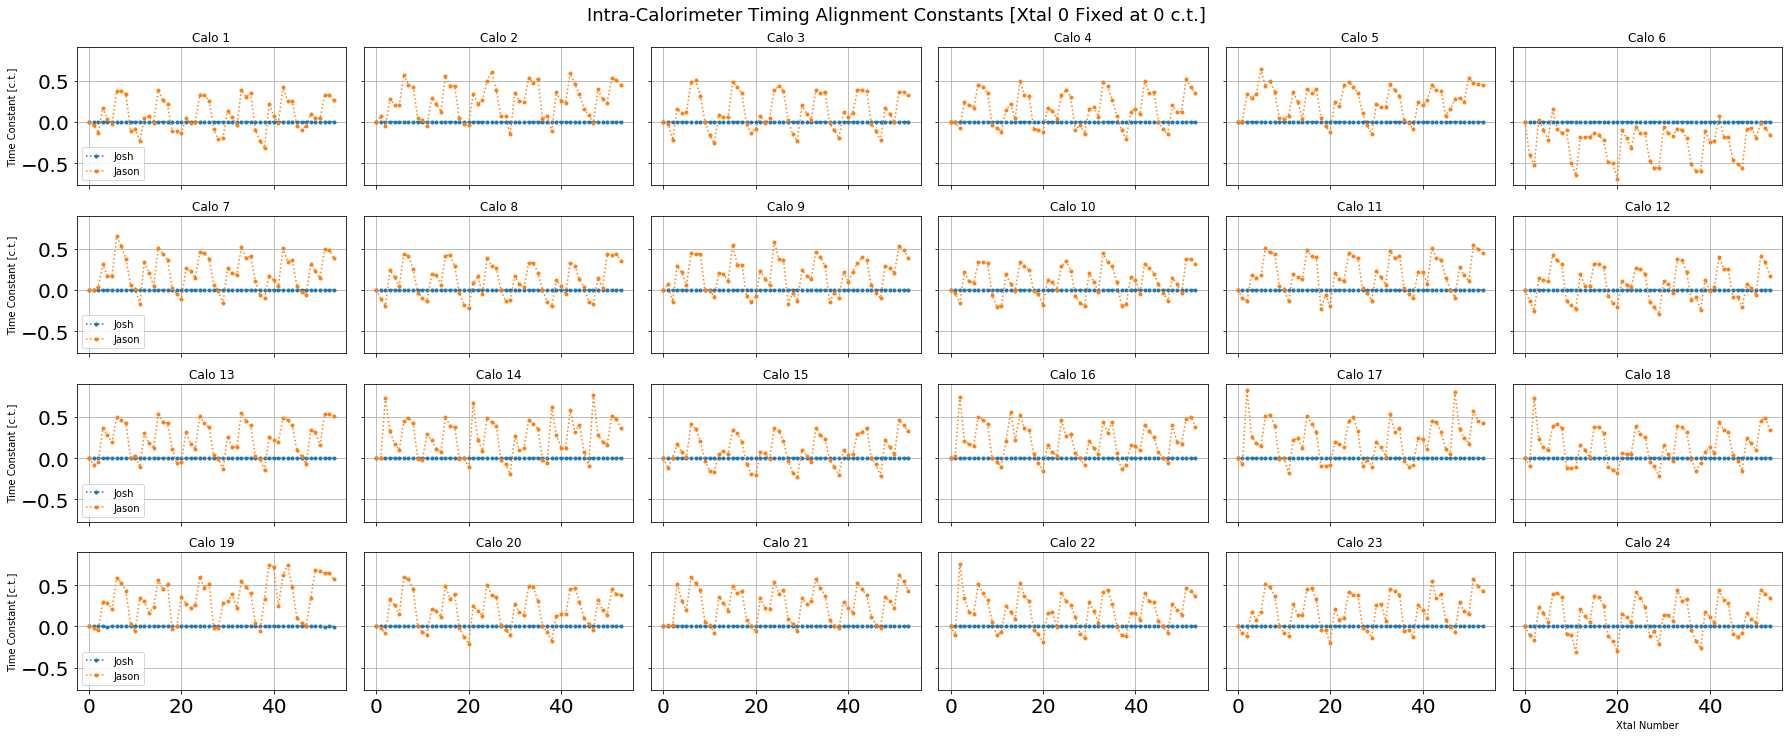

In [28]:
fig, axs = plt.subplots(4,6,figsize=(25,10), sharex=True, sharey=True)
#plt.ylim(-0.3,0.6)
ax = flatten2dArray(axs)
for calo in range(24):
    #ax[calo].plot([i for i in range(54)], myConstants[calo], ".:", label="Josh Pre Disk")
    ax[calo].plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Josh")
    ax[calo].plot([i for i in range(54)], jasonConstants[calo], ".:", label="Jason")
    #ax[calo].plot([i for i in range(54)], jasonConstantsF2[calo], ".:", label="Jason with Xtals Excluded")
    #ax[calo].plot([i for i in range(54)], aaronConstants[calo], ".:", label="Aaron")
    ax[calo].set_title("Calo "+str(calo+1))
    ax[calo].grid()
    if(calo % 6 == 0):
        ax[calo].set_ylabel("Time Constant [c.t.]")
        ax[calo].legend(loc=3)
plt.suptitle("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel("Xtal Number")
plt.tight_layout()
#plt.ylim(-1.2,1.2)
plt.show()

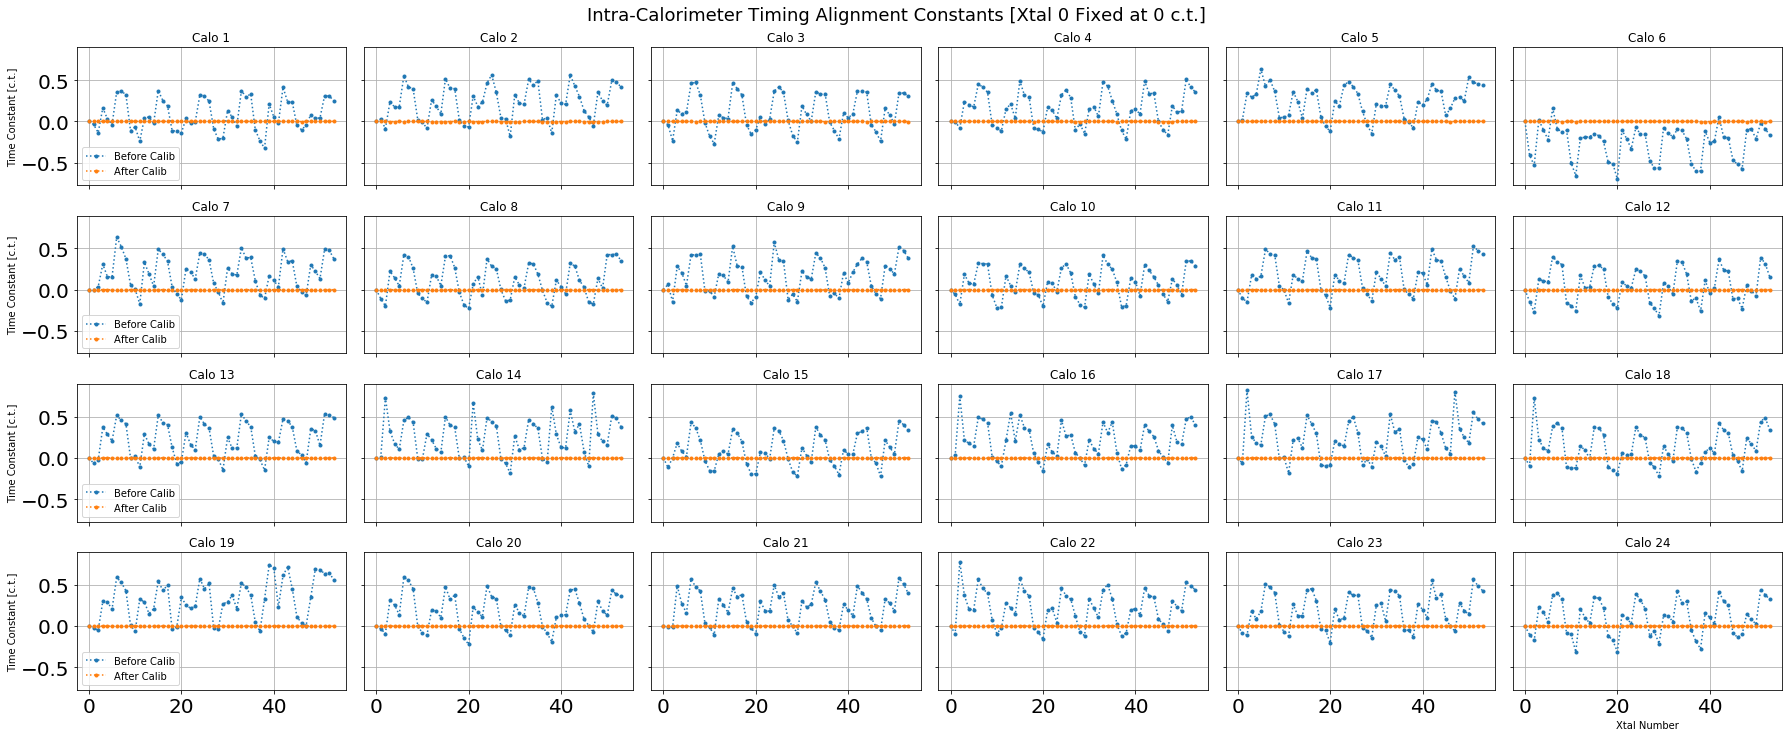

In [30]:
fig, axs = plt.subplots(4,6,figsize=(25,10), sharex=True, sharey=True)
#plt.ylim(-0.3,0.6)
ax = flatten2dArray(axs)
for calo in range(24):
    ax[calo].plot([i for i in range(54)], myConstants[calo], ".:", label="Before Calib")
    ax[calo].plot([i for i in range(54)], caloSVD[calo][1], ".:", label="After Calib")
    #ax[calo].plot([i for i in range(54)], jasonConstantsF2[calo], ".:", label="Jason with Xtals Excluded")
    #ax[calo].plot([i for i in range(54)], aaronConstants[calo], ".:", label="Aaron")
    ax[calo].set_title("Calo "+str(calo+1))
    ax[calo].grid()
    if(calo % 6 == 0):
        ax[calo].set_ylabel("Time Constant [c.t.]")
        ax[calo].legend(loc=3)
plt.suptitle("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel("Xtal Number")
plt.tight_layout()
#plt.ylim(-1.2,1.2)
plt.show()

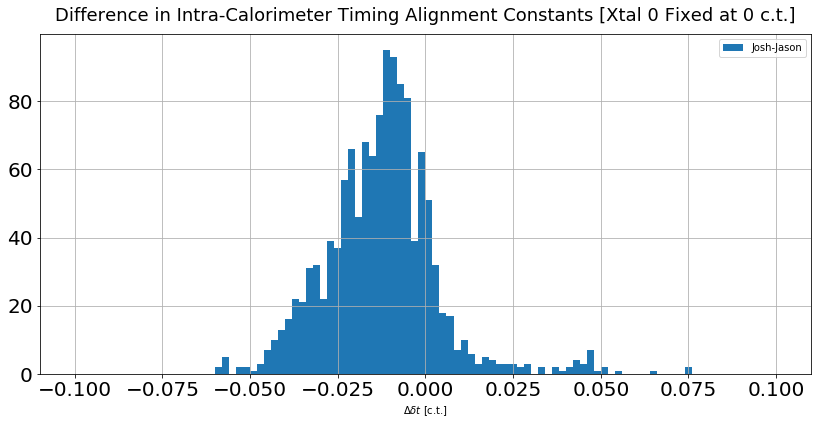

In [29]:
fig, ax = plt.subplots(figsize=(12,6), sharex=True, sharey=True)

allDiffs = []
for calo in range(24):
    diff = [float(x)-y for (x,y) in zip(caloSVD[calo][1], jasonConstants[calo])]
    allDiffs += diff
plotRange = (-0.1,0.1)
plotBins = 100
ax.hist(allDiffs, bins=plotBins, label="Josh-Jason", range=plotRange)
#ax[calo].hist(diff, bins=80, label="Josh-Jason", range=(-0.5,0.5), color=colors[int(np.floor(calo/4) % 2)])
ax.grid()
#ax.set_yscale("log")

plt.title("Difference in Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel(r"$\Delta \delta t$ [c.t.]")
plt.tight_layout()
#plt.ylim(0.01,100)
#plt.xlim(-0.5,0.5)
plt.legend()
plt.show()

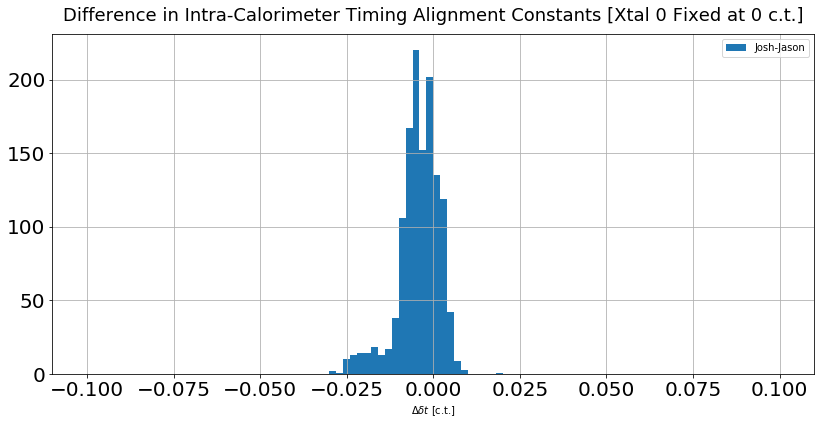

In [30]:
fig, ax = plt.subplots(figsize=(12,6), sharex=True, sharey=True)

allDiffs = []
for calo in range(24):
    diff = [float(x)-y for (x,y) in zip(caloSVD[calo][1], myConstants[calo])]
    allDiffs += diff
plotRange = (-0.1,0.1)
plotBins = 100
ax.hist(allDiffs, bins=plotBins, label="Josh-Jason", range=plotRange)
#ax[calo].hist(diff, bins=80, label="Josh-Jason", range=(-0.5,0.5), color=colors[int(np.floor(calo/4) % 2)])
ax.grid()
#ax.set_yscale("log")

plt.title("Difference in Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel(r"$\Delta \delta t$ [c.t.]")
plt.tight_layout()
#plt.ylim(0.01,100)
#plt.xlim(-0.5,0.5)
plt.legend()
plt.show()

---

### Now lets generate the fcl file for the timing offsets

In [31]:
globalTimeCorrections = [0 for i in range(24)]

ding = pandas.read_csv("./globalTimeAlignmentConstants.csv", header=None)
ding.head()
globalTimeCorrections = ding[0].to_list()

print(globalTimeCorrections)

[-0.31097348443701034, -0.07237127788818551, -0.24607183032971305, -0.2791960663860969, 0.5359740575959936, 0.4328336965132536, 0.32797262955489315, 0.5803481954504488, -1.288913059628845, -1.3995787147395151, -1.1143380194255177, -1.106958686614878, -0.5053333762926885, -0.3817242563338181, -0.0918438276218448, -0.22640120825839266, -0.7324488332571047, -0.5048758809458923, -0.495976477877886, -0.5590612365997518, 0.4648622906144235, 5.07927033766009e-15, 0.2268691182047761, 0.04272030896320474, -4.984965229275998]
